This notebook will implement combining D + P dataset

The dataset is balance 
This is before 
Number of LABEL=1 entries: 991
  S: 723
  T: 167
  Y: 101
Number of LABEL=0 entries: 989
  S: 722
  T: 167
  Y: 100

  Now we add some more from phos dataset and it looks like this
  Number of LABEL=1 entries: 
  S: 723
  T: 723
  Y: 723
Number of LABEL=0 entries: 
  S: 722
  T: 722
  Y: 722
  We do not sample any more S entries as it is already balanced

In [ ]:
import os.path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader

import re
import numpy as np
import pandas as pd
import copy

import transformers, datasets
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.t5.modeling_t5 import T5Config, T5PreTrainedModel, T5Stack
from transformers.utils.model_parallel_utils import assert_device_map, get_device_map
from transformers import T5EncoderModel, T5Tokenizer
from transformers import TrainingArguments, Trainer, set_seed

from evaluate import load
from datasets import Dataset

from tqdm import tqdm
import random

from scipy import stats
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
#!pip install umap-learn
import umap

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
print("Torch version: ",torch.__version__)
print("Cuda version: ",torch.version.cuda)
print("Numpy version: ",np.__version__)
print("Pandas version: ",pd.__version__)
print("Transformers version: ",transformers.__version__)
print("Datasets version: ",datasets.__version__)

Torch version:  2.1.1+cu121
Cuda version:  12.1
Numpy version:  1.26.2
Pandas version:  2.1.3
Transformers version:  4.35.2
Datasets version:  2.15.0


In [7]:
from Bio import SeqIO
import pandas as pd

sequences = []

local_fasta_path = '../src/input_datasets/merged_output_D+P_balance_ST.fasta'

# Load FASTA file using Biopython
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

local_fasta_path = '../src/input_datasets/merged_output_D+P_balance_Y.fasta'

for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display the dataframe
df.head(5)


,name,sequence,label
0,sp|Q8WWI1|LMO7_HUMAN%260%276,SCSSDITLRGGREGFESDTDSEFTFKMQDYNKD,1
1,sp|sp|Q07157|ZO1_HUMAN|Tight,RSKGKLKMVVQRDERATLLNVPDLSDSIHSANA,1
2,sp|P24928|RPB1_HUMAN%1775%1791,NYTPTSPNYSPTSPSYSPTSPSYSPTSPSYSPS,1
3,sp|sp|Q9Y2U8|MAN1_HUMAN|Inner,PHSWWGARRPAGPELQTPPGKDGAVEDEEGEGE,1
4,sp|Q14980|NUMA1_HUMAN%2061%2077,NSLLRRGASKKALSKASPNTRSGTRRSPRIATT,1


In [6]:
# # Function to get the middle character
# def get_middle_char(sequence):
#     chars = list(sequence)
#     middle_index = len(chars) // 2
#     return chars[middle_index]

# # Apply the function to get the middle characters
# df['middle_char'] = df['sequence'].apply(get_middle_char)

In [7]:
# # Function to count 'S', 'T', 'Y' in a sequence
# def count_chars(sequence, char):
#     return sequence.count(char)

# # Count the occurrences of 'S', 'T', and 'Y' in the sequences
# df['count_S'] = df['middle_char'].apply(lambda seq: count_chars(seq, 'S'))
# df['count_T'] = df['middle_char'].apply(lambda seq: count_chars(seq, 'T'))
# df['count_Y'] = df['middle_char'].apply(lambda seq: count_chars(seq, 'Y'))

# # Sum the counts to get the total occurrences in the DataFrame
# total_S = df['count_S'].sum()
# total_T = df['count_T'].sum()
# total_Y = df['count_Y'].sum()

# print(f"Total number of 'S': {total_S}")
# print(f"Total number of 'T': {total_T}")
# print(f"Total number of 'Y': {total_Y}")

In [8]:
# # Group by label and sum the counts
# grouped_counts = df.groupby('label')[['count_S', 'count_T', 'count_Y']].sum().reset_index()

# # Display the grouped counts
# print(grouped_counts)

In [9]:
# # Separate the DataFrame by middle character
# df_S = df[df['middle_char'] == 'S']
# df_T = df[df['middle_char'] == 'T']
# df_Y = df[df['middle_char'] == 'Y']

# # Separate each subset by label
# df_S_0 = df_S[df_S['label'] == 0]
# df_S_1 = df_S[df_S['label'] == 1]
# df_T_0 = df_T[df_T['label'] == 0]
# df_T_1 = df_T[df_T['label'] == 1]
# df_Y_0 = df_Y[df_Y['label'] == 0]
# df_Y_1 = df_Y[df_Y['label'] == 1]


In [10]:
# from sklearn.utils import resample
# # Desired number of samples per group
# n_samples_S = 500
# n_sampple_T = 300
# n_sampple_Y = 200
# # Perform stratified sampling
# df_S_0_resampled = resample(df_S_0, replace=False, n_samples=n_samples_S, random_state=42)
# df_S_1_resampled = resample(df_S_1, replace=False, n_samples=n_samples_S, random_state=42)
# df_T_0_resampled = resample(df_T_0, replace=True, n_samples=n_sampple_T, random_state=42)
# df_T_1_resampled = resample(df_T_1, replace=True, n_samples=n_sampple_T, random_state=42)
# df_Y_0_resampled = resample(df_Y_0, replace=True, n_samples=n_sampple_Y, random_state=42)
# df_Y_1_resampled = resample(df_Y_1, replace=True, n_samples=n_sampple_Y, random_state=42)



In [11]:
# # Combine the resampled subsets
# balanced_df = pd.concat([
#     df_S_0_resampled, df_S_1_resampled,
#     df_T_0_resampled, df_T_1_resampled,
#     df_Y_0_resampled, df_Y_1_resampled
# ])

# # Shuffle the combined DataFrame
# balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# print("Balanced DataFrame:")
# print(balanced_df)


In [12]:
# from sklearn.model_selection import train_test_split

# # Split the dataset into training and validation sets
# my_train, my_valid = train_test_split(
#     balanced_df, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=balanced_df[['label', 'middle_char']]
# )

# my_train=my_train[["sequence", "label"]]
# my_valid=my_valid[["sequence","label"]]


# # Print the first 5 rows of the training set
# print("Training Set:")
# print(my_train.shape)

# # Print the first 5 rows of the validation set
# print("\nValidation Set:")
# print(my_valid.shape)

In [8]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
my_train, my_valid = train_test_split(df, test_size=0.2, random_state=42)

my_train=my_train[["sequence", "label"]]
my_valid=my_valid[["sequence","label"]]


# Print the first 5 rows of the training set
print("Training Set:")
print(my_train.shape)

# Print the first 5 rows of the validation set
print("\nValidation Set:")
print(my_valid.shape)

Training Set:
(3468, 2)

Validation Set:
(867, 2)


In [9]:
# Modifies an existing transformer and introduce the LoRA layers

class LoRAConfig:
    def __init__(self, lora_rank=8, lora_init_scale=0.01, lora_scaling_rank=2):
        self.lora_rank = lora_rank
        self.lora_init_scale = lora_init_scale
        self.lora_modules = ".*SelfAttention|.*EncDecAttention"
        self.lora_layers = "q|k|v|o"
        self.trainable_param_names = ".*layer_norm.*|.*lora_[ab].*"
        self.lora_scaling_rank = lora_scaling_rank
        # lora_modules and lora_layers are specified with regular expressions
        # see https://www.w3schools.com/python/python_regex.asp for reference
        
class LoRALinear(nn.Module):
    def __init__(self, linear_layer, rank, scaling_rank, init_scale):
        super().__init__()
        self.in_features = linear_layer.in_features
        self.out_features = linear_layer.out_features
        self.rank = rank
        self.scaling_rank = scaling_rank
        self.weight = linear_layer.weight
        self.bias = linear_layer.bias
        if self.rank > 0:
            self.lora_a = nn.Parameter(torch.randn(rank, linear_layer.in_features) * init_scale)
            if init_scale < 0:
                self.lora_b = nn.Parameter(torch.randn(linear_layer.out_features, rank) * init_scale)
            else:
                self.lora_b = nn.Parameter(torch.zeros(linear_layer.out_features, rank))
        if self.scaling_rank:
            self.multi_lora_a = nn.Parameter(
                torch.ones(self.scaling_rank, linear_layer.in_features)
                + torch.randn(self.scaling_rank, linear_layer.in_features) * init_scale
            )
            if init_scale < 0:
                self.multi_lora_b = nn.Parameter(
                    torch.ones(linear_layer.out_features, self.scaling_rank)
                    + torch.randn(linear_layer.out_features, self.scaling_rank) * init_scale
                )
            else:
                self.multi_lora_b = nn.Parameter(torch.ones(linear_layer.out_features, self.scaling_rank))

    def forward(self, input):
        if self.scaling_rank == 1 and self.rank == 0:
            # parsimonious implementation for ia3 and lora scaling
            if self.multi_lora_a.requires_grad:
                hidden = F.linear((input * self.multi_lora_a.flatten()), self.weight, self.bias)
            else:
                hidden = F.linear(input, self.weight, self.bias)
            if self.multi_lora_b.requires_grad:
                hidden = hidden * self.multi_lora_b.flatten()
            return hidden
        else:
            # general implementation for lora (adding and scaling)
            weight = self.weight
            if self.scaling_rank:
                weight = weight * torch.matmul(self.multi_lora_b, self.multi_lora_a) / self.scaling_rank
            if self.rank:
                weight = weight + torch.matmul(self.lora_b, self.lora_a) / self.rank
            return F.linear(input, weight, self.bias)

    def extra_repr(self):
        return "in_features={}, out_features={}, bias={}, rank={}, scaling_rank={}".format(
            self.in_features, self.out_features, self.bias is not None, self.rank, self.scaling_rank
        )


def modify_with_lora(transformer, config):
    for m_name, module in dict(transformer.named_modules()).items():
        if re.fullmatch(config.lora_modules, m_name):
            for c_name, layer in dict(module.named_children()).items():
                if re.fullmatch(config.lora_layers, c_name):
                    assert isinstance(
                        layer, nn.Linear
                    ), f"LoRA can only be applied to torch.nn.Linear, but {layer} is {type(layer)}."
                    setattr(
                        module,
                        c_name,
                        LoRALinear(layer, config.lora_rank, config.lora_scaling_rank, config.lora_init_scale),
                    )
    return transformer

In [10]:
class ClassConfig:
    def __init__(self, dropout=0.7, num_labels=2):
        self.dropout_rate = dropout
        self.num_labels = num_labels

class T5EncoderClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, class_config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(class_config.dropout_rate)
        self.out_proj = nn.Linear(config.hidden_size, class_config.num_labels)
        
        # Trainable emphasis factor
        # self.emphasis_factor = nn.Parameter(torch.tensor(1.0))
        
    # def forward(self, hidden_states):
    #     seq_length = hidden_states.size(1)
    #     middle_idx = seq_length // 2
    #     middle_embedding = hidden_states[:, middle_idx, :]

    #     # Apply trainable emphasis factor
    #     emphasized_middle_embedding = middle_embedding * self.emphasis_factor

    #     # Combine with the average embedding
    #     average_embedding = torch.mean(hidden_states, dim=1)
    #     combined_embedding = emphasized_middle_embedding + average_embedding

    #     x = self.dropout(combined_embedding)
    #     x = self.dense(x)
    #     x = torch.tanh(x)
    #     x = self.dropout(x)
    #     logits = self.out_proj(x)
    #     return logits

    # def forward(self, hidden_states):

    #     hidden_states =  torch.mean(hidden_states,dim=1)  # avg embedding

    #     hidden_states = self.dropout(hidden_states)
    #     hidden_states = self.dense(hidden_states)
    #     hidden_states = torch.tanh(hidden_states)
    #     hidden_states = self.dropout(hidden_states)
    #     hidden_states = self.out_proj(hidden_states)
    #     return hidden_states
    
    def forward(self, hidden_states):
        # Original sequence length and middle index
        seq_length = hidden_states.size(1)
        middle_idx = seq_length // 2

        # Extract the middle embedding vector
        middle_embedding = hidden_states[:, middle_idx, :]

        # Amplify the influence of the middle embedding
        amplified_middle_embedding = middle_embedding * 2

        # Combine with average to retain context
        average_embedding = torch.mean(hidden_states, dim=1)
        combined_embedding = 0.5 * amplified_middle_embedding + 0.5 * average_embedding

        # Classification layers
        x = self.dropout(combined_embedding)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        logits = self.out_proj(x)
        return logits


class T5EncoderForSimpleSequenceClassification(T5PreTrainedModel):

    def __init__(self, config: T5Config, class_config):
        super().__init__(config)
        self.num_labels = class_config.num_labels
        self.config = config

        self.shared = nn.Embedding(config.vocab_size, config.d_model)

        encoder_config = copy.deepcopy(config)
        encoder_config.use_cache = False
        encoder_config.is_encoder_decoder = False
        self.encoder = T5Stack(encoder_config, self.shared)

        self.dropout = nn.Dropout(class_config.dropout_rate) 
        self.classifier = T5EncoderClassificationHead(config, class_config)

        # Initialize weights and apply final processing
        self.post_init()

        # Model parallel
        self.model_parallel = False
        self.device_map = None

    def parallelize(self, device_map=None):
        self.device_map = (
            get_device_map(len(self.encoder.block), range(torch.cuda.device_count()))
            if device_map is None
            else device_map
        )
        assert_device_map(self.device_map, len(self.encoder.block))
        self.encoder.parallelize(self.device_map)
        self.classifier = self.classifier.to(self.encoder.first_device)
        self.model_parallel = True

    def deparallelize(self):
        self.encoder.deparallelize()
        self.encoder = self.encoder.to("cpu")
        self.model_parallel = False
        self.device_map = None
        torch.cuda.empty_cache()

    def get_input_embeddings(self):
        return self.shared

    def set_input_embeddings(self, new_embeddings):
        self.shared = new_embeddings
        self.encoder.set_input_embeddings(new_embeddings)

    def get_encoder(self):
        return self.encoder

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=True,
            return_dict=return_dict,
        )

        hidden_states = outputs[0]
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [11]:
def PT5_classification_model(num_labels, dropout, lora_rank, lora_init_scale, lora_scaling_rank):
    # Load PT5 and tokenizer
    model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")
    tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50") 
    
    # Create new Classifier model with PT5 dimensions
    class_config=ClassConfig(num_labels=num_labels, dropout=dropout)
    class_model=T5EncoderForSimpleSequenceClassification(model.config,class_config)
    
    # Set encoder and embedding weights to checkpoint weights
    class_model.shared=model.shared
    class_model.encoder=model.encoder    
    
    # Delete the checkpoint model
    model=class_model
    del class_model
    
    # Print number of trainable parameters
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ProtT5_Classfier\nTrainable Parameter: "+ str(params))    
 
    # Add model modification lora
    config = LoRAConfig(lora_rank=lora_rank, lora_init_scale=lora_init_scale, lora_scaling_rank=lora_scaling_rank)
    
    # Add LoRA layers
    model = modify_with_lora(model, config)
    
    # Freeze Embeddings and Encoder (except LoRA)
    for (param_name, param) in model.shared.named_parameters():
                param.requires_grad = False
    for (param_name, param) in model.encoder.named_parameters():
                param.requires_grad = False       

    for (param_name, param) in model.named_parameters():
            if re.fullmatch(config.trainable_param_names, param_name):
                param.requires_grad = True

    # Print trainable Parameter          
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ProtT5_LoRA_Classfier\nTrainable Parameter: "+ str(params) + "\n")
    
    return model, tokenizer

In [12]:
# Deepspeed config for optimizer CPU offload

ds_config = {
    "fp16": {
        "enabled": "auto",
        "loss_scale": 0,
        "loss_scale_window": 1000,
        "initial_scale_power": 16,
        "hysteresis": 2,
        "min_loss_scale": 1
    },

    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": "auto",
            "betas": "auto",
            "eps": "auto",
            "weight_decay": "auto"
        }
    },

    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": "auto",
            "warmup_max_lr": "auto",
            "warmup_num_steps": "auto"
        }
    },

    "zero_optimization": {
        "stage": 2,
        "offload_optimizer": {
            "device": "cpu",
            "pin_memory": True
        },
        "allgather_partitions": True,
        "allgather_bucket_size": 2e8,
        "overlap_comm": True,
        "reduce_scatter": True,
        "reduce_bucket_size": 2e8,
        "contiguous_gradients": True
    },

    "gradient_accumulation_steps": "auto",
    "gradient_clipping": "auto",
    "steps_per_print": 2000,
    "train_batch_size": "auto",
    "train_micro_batch_size_per_gpu": "auto",
    "wall_clock_breakdown": False
}

In [13]:
from transformers import TrainerCallback, TrainerState, TrainerControl

class EarlyStoppingCallback(TrainerCallback):
    """Custom early stopping callback that can monitor loss or accuracy."""
    
    def __init__(self, metric_name='eval_loss', early_stopping_patience=3, minimize=True):
        """
        Args:
            metric_name (str): Metric to monitor, default 'eval_loss'.
            early_stopping_patience (int): Number of checks with no improvement after which training will be stopped.
            minimize (bool): Set to True if the metric should be minimized, False if it should be maximized.
        """
        self.metric_name = metric_name
        self.early_stopping_patience = early_stopping_patience
        self.early_stopping_counter = 0
        self.minimize = minimize
        self.best_metric = float('inf') if minimize else float('-inf')
    
    def on_evaluate(self, args, state, control, **kwargs):
        current_metric = kwargs['metrics'][self.metric_name]
        
        if (self.minimize and current_metric < self.best_metric) or (not self.minimize and current_metric > self.best_metric):
            self.best_metric = current_metric
            self.early_stopping_counter = 0
        else:
            self.early_stopping_counter += 1
        
        if self.early_stopping_counter >= self.early_stopping_patience:
            control.should_training_stop = True
            print(f'Stopping early! No improvement in {self.metric_name} for {self.early_stopping_patience} evaluation steps.')


class MultiObjectiveEarlyStoppingCallback(TrainerCallback):
    def __init__(self, early_stopping_patience, min_delta=0.001):
        self.early_stopping_patience = early_stopping_patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.best_val_accuracy = float('-inf')
        self.wait = 0

    def on_evaluate(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        # Extract current validation loss and accuracy
        val_loss = kwargs['metrics']['eval_loss']
        val_accuracy = kwargs['metrics']['eval_accuracy']

        # Check if current loss and accuracy improved significantly
        loss_improved = (self.best_val_loss - val_loss) > self.min_delta
        accuracy_improved = (val_accuracy - self.best_val_accuracy) > self.min_delta

        if loss_improved or accuracy_improved:
            # Update best scores and reset wait time
            self.best_val_loss = min(self.best_val_loss, val_loss)
            self.best_val_accuracy = max(self.best_val_accuracy, val_accuracy)
            self.wait = 0
        else:
            # If no improvement, increment the wait counter
            self.wait += 1
            if self.wait >= self.early_stopping_patience:
                # If wait exceeds the patience, stop training
                control.should_training_stop = True
                print(f"Stopping early at epoch {state.epoch}: No improvement in loss or accuracy for {self.early_stopping_patience} evaluations.")
                
class MultiObjectiveEarlyStoppingAndSaveCallback(TrainerCallback):
    def __init__(self, early_stopping_patience, min_delta=0.001, output_dir='./model_output', filename='finetuned_model'):
        self.early_stopping_patience = early_stopping_patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.best_val_accuracy = float('-inf')
        self.wait = 0
        self.output_dir = output_dir
        self.filename = filename
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

    def on_evaluate(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        val_loss = kwargs['metrics']['eval_loss']
        val_accuracy = kwargs['metrics']['eval_accuracy']
        model = kwargs['model']

        loss_improved = (self.best_val_loss - val_loss) > self.min_delta
        accuracy_improved = (val_accuracy - self.best_val_accuracy) > self.min_delta

        if loss_improved or accuracy_improved:
            self.best_val_loss = min(self.best_val_loss, val_loss)
            self.best_val_accuracy = max(self.best_val_accuracy, val_accuracy)
            self.wait = 0
            # Save the model as the best so far
            self.save_finetuned_parameters(model, os.path.join(self.output_dir, self.filename))
            print(f"Saved improved model to {self.output_dir}/{self.filename}")
        else:
            self.wait += 1
            if self.wait >= self.early_stopping_patience:
                control.should_training_stop = True
                print(f"Stopping early at epoch {state.epoch}: No improvement in loss or accuracy for {self.early_stopping_patience} evaluations.")
                
    def save_finetuned_parameters(self, model, filepath):
        # Create a dictionary to hold the non-frozen parameters
        non_frozen_params = {n: p for n, p in model.named_parameters() if p.requires_grad}
        # Save only the finetuned parameters 
        torch.save(non_frozen_params, filepath)

In [14]:
from sklearn.metrics import accuracy_score
#!pip install seaborn
import seaborn as sns
import gc

# Set random seeds for reproducibility of your trainings run
def set_seeds(s):
    torch.manual_seed(s)
    np.random.seed(s)
    random.seed(s)
    set_seed(s)

def apply_umap(embeddings, n_components=2, min_dist=0.01):
    umap_model = umap.UMAP(n_components=n_components)
    umap_embeddings = umap_model.fit_transform(embeddings)
    return umap_embeddings

def plot_umap(embeddings, labels):
    data = {"UMAP1": embeddings[:, 0], "UMAP2": embeddings[:, 1], "Label": labels}
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="UMAP1", y="UMAP2", hue="Label", data=df, palette={0: "blue", 1: "magenta"}, s=50, alpha=0.9)
    plt.title("UMAP Visualization of Embeddings")
    plt.savefig("../Plots/UMAP_Visualization_of_Embeddings_new.pdf")
    plt.show()
    
# Main training fuction
def train_per_protein(
        train_dataset,         #training data
        valid_dataset,         #validation data      
        weight_decay,
        warmup_pct,
        num_labels= 2,    #1 for regression, >1 for classification
    
        # effective training batch size is batch * accum
        # we recommend an effective batch size of 8 
        batch= 4,         #for training
        accum= 2,         #gradient accumulation
    
        val_batch = 16,   #batch size for evaluation
        epochs=1,       #training epochs
        lr= 3e-4,         #recommended learning rate
        seed= 42,         #random seed
        deepspeed=False,  #if gpu is large enough disable deepspeed for training speedup
        gpu= 1,
        dropout=0.5, #dropout rate
         #L2 weight regularization
        lora_rank=4,      #lora rank
        lora_init_scale=0.01, #lora scaling rank
        lora_scaling_rank=1,       #lora a
        ):         #gpu selection (1 for first gpu)

    # Set gpu device
    os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu-1)
    
    # Set all random seeds
    set_seeds(seed)
    
    # load model
    model, tokenizer = PT5_classification_model(num_labels=num_labels, dropout=dropout, lora_rank=lora_rank, lora_init_scale=lora_init_scale, lora_scaling_rank=lora_scaling_rank)

    # Huggingface Trainer arguments
    total_steps = epochs * len(train_dataset) // batch
    warmup_steps = int(warmup_pct * total_steps)
     
    # Define TrainingArguments
    args = TrainingArguments(
        output_dir='./results',              # where to save the model
        evaluation_strategy='epoch',         # evaluation is done at the end of each epoch
        logging_strategy='epoch',
        save_strategy='no',
        learning_rate=lr,                    # initial learning rate
        per_device_train_batch_size=batch,   # batch size per device
        gradient_accumulation_steps=accum,   # gradient accumulation steps
        num_train_epochs=epochs,             # number of epochs to train
        weight_decay=weight_decay,           # L2 weight regularization
        warmup_steps=warmup_steps,           # 10% of total steps
        load_best_model_at_end=False,         # load the best model at the end of training
        seed=seed,                           # random seed
        push_to_hub=False,                   # if you want to push model to the hub (Hugging Face Model Hub)
        logging_dir='./logs',
    )
    # metric_for_best_model='eval_loss|accuracy'

    # Metric definition for validation data
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred.predictions, eval_pred.label_ids
        # Check if predictions have the expected shape
        if isinstance(predictions, tuple):
            predictions = predictions[0]
        if predictions.ndim > 1 and predictions.shape[1] > 1:
            predictions = np.argmax(predictions, axis=1)
        # Now, compute the metric (e.g., accuracy)
        accuracy = accuracy_score(labels, predictions)
        
        # Return the metric(s) as a dictionary
        return {"accuracy": accuracy}
    
    # For minimizing loss
    early_stopping_loss = EarlyStoppingCallback(metric_name='eval_loss', early_stopping_patience=3, minimize=True)

    # For maximizing accuracy
    early_stopping_accuracy = EarlyStoppingCallback(metric_name='eval_accuracy', early_stopping_patience=3, minimize=False)
    # Trainer          
    trainer = Trainer(
        model,
        args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[MultiObjectiveEarlyStoppingAndSaveCallback(
            early_stopping_patience=3,
            min_delta=0.001,
            output_dir='./model_output',
            filename='finetuned_model_D_and_P_balance_dataset.pth'
        )],
    )    

    def get_embeddings(model, tokenizer, sequences, batch_size=32, device="cuda"):
        embeddings = []
        model = model.to(device)
        model.eval()
    
        # Iterate over the sequences in batches
        for i in range(0, len(sequences), batch_size):
            # Extract a batch of sequences
            batch = sequences[i:i + batch_size]
    
            # Tokenize the batch using the specified tokenizer and convert to PyTorch tensors
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    
            with torch.no_grad():
                # Forward pass through the model to obtain outputs
                outputs = model(**inputs)
    
            # Extract hidden states from the second-to-last layer (penultimate layer)
            hidden_states = outputs.hidden_states[-2].detach().cpu().numpy()
    
            # Take the embeddings from the second-to-last layer
            embeddings_from_layer = hidden_states[:, 0, :]
    
            # Extend the list with the generated embeddings
            embeddings.extend(embeddings_from_layer)
    
            print(f"Batch {i // batch_size + 1}, Second-to-Last Layer Embeddings Shape: {embeddings_from_layer.shape}")
    
        return np.array(embeddings)

        
    # Train model
    trainer.train()

    # Get the best model
    # model = trainer.model
    # Ensure the best model is loaded
    best_model_path = os.path.join('./model_output', 'finetuned_model_D_and_P_balance_dataset.pth')
    if os.path.exists(best_model_path):
        state_dict = torch.load(best_model_path)
        model.load_state_dict(state_dict, strict=False)
        print(f"Loaded best model from {best_model_path}")
        
    # Evaluate the best model
    eval_results = trainer.evaluate()
    print(eval_results)
    
    # Print the current learning rate
    # current_lr = trainer.optimizer.param_groups[0]['lr']
    # print(f"Current learning rate: {current_lr}")
    
    # valid_sequences = list(valid_dataset['sequence'])
    # valid_embeddings = get_embeddings(model, tokenizer, valid_sequences)

    # # Apply UMAP for dimensionality reduction
    # umap_embeddings = apply_umap(valid_embeddings)

    # # Plot UMAP embeddings
    # labels = list(valid_dataset['label'])
    # plot_umap(umap_embeddings, labels)
    
    torch.cuda.empty_cache()
    gc.collect()

    return tokenizer, model, trainer.state.log_history


In [15]:
# Dataset creation
def create_dataset(tokenizer,seqs,labels):
    tokenized = tokenizer(seqs, max_length=1024, padding=True, truncation=True)
    dataset = Dataset.from_dict(tokenized)
    dataset = dataset.add_column("labels", labels)

    return dataset

# Initialize the tokenizer
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50") 

train_df = my_train
valid_df = my_valid

# Preprocess inputs
# Replace uncommon AAs with "X"
train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
valid_df["sequence"]=valid_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
# Add spaces between each amino acid for PT5 to correctly use them
train_df['sequence']=train_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)
valid_df['sequence']=valid_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)

# Create Datasets
train_set=create_dataset(tokenizer,list(train_df['sequence']),list(train_df['label']))
valid_set=create_dataset(tokenizer,list(valid_df['sequence']),list(valid_df['label']))

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [24]:
%rm all_dephos_withLORA_datasetloader.sqlite3

{'lr': 0.00010175943017273118, 'batch': 8, 'accum': 2, 'dropout_rate': 0.4882243131202929, 'weight_decay': 0.00014993579804161342, 'warmup_pct': 0.18496515086758566, 'lora_rank': 24, 'lora_init_scale': 0.01370043600756871, 'lora_scaling_rank': 5}

In [24]:
# torch.cuda.empty_cache()

In [16]:
tokenizer, model, history = train_per_protein(train_set, valid_set, num_labels=2, batch=8, accum=2, epochs=20, seed=42, lr=0.00010175943017273118, dropout=0.4882243131202929, weight_decay=0.00014993579804161342, warmup_pct=0.18496515086758566, lora_rank=24, lora_init_scale=0.01370043600756871, lora_scaling_rank=5)

ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 15355907.0



Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [12]:
import optuna

def objective(trial):
    # Set the seed for reproducibility in each trial
    # seed = trial.suggest_int('seed', 0, 10000)
    # set_seeds(seed)
    
    # Hyperparameters to be optimized
    # Updated to use suggest_float with log=True for loguniform distribution
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch = trial.suggest_categorical('batch', [1, 2, 4, 8])
    accum = trial.suggest_categorical('accum', [2, 4, 8])
    # Updated to use suggest_float for uniform distribution
    dropout = trial.suggest_float('dropout_rate', 0.1, 0.9)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    warmup_pct = trial.suggest_float("warmup_pct", 0.01, 0.3)  # Warmup percentage between 1% and 30%
    lora_rank = trial.suggest_int('lora_rank', 4, 32, step=4)
    lora_init_scale = trial.suggest_float('lora_init_scale', 1e-4, 1e-1, log=True)
    lora_scaling_rank = trial.suggest_int('lora_scaling_rank', 1, 8)


    # Training and evaluation
    tokenizer, model, history = train_per_protein(
        train_dataset=train_set, 
        valid_dataset=valid_set, 
        num_labels=2, 
        batch=batch, 
        accum=accum, 
        epochs=10,  # Fewer epochs for the trial runs
        lr=lr,
        dropout=dropout,
        weight_decay=weight_decay,
        warmup_pct=warmup_pct,
        lora_rank=lora_rank,
        lora_init_scale=lora_init_scale,
        lora_scaling_rank=lora_scaling_rank,
        # seed=seed
    )
    
    # Clear GPU memory
    # torch.cuda.empty_cache()
    
    print("History: ", history)
    
    # Extract the last validation accuracy from the history
    val_accuracy = [entry['eval_accuracy'] for entry in history if 'eval_accuracy' in entry][-1]
    val_loss = [entry['eval_loss'] for entry in history if 'eval_loss' in entry][-1]
    return val_loss, val_accuracy

directions=['minimize', 'maximize']  # Set the direction to maximize the validation accuracy, can also be 'minimize'
study = optuna.create_study(directions=directions,
                            storage="sqlite:///finetuned_model_D_and_P_balance_dataset.sqlite3",  # Specify the storage URL here.
                            study_name="finetuned_model_D_and_P_balance_dataset")
study.optimize(objective, n_trials=30)  # Adjust the number of trials based on your computational resources

# Analyzing results
pareto_front = study.best_trials  # Get the Pareto front (best non-dominated solutions)
for trial in pareto_front:
    print(f"Loss: {trial.values[0]}, Accuracy: {trial.values[1]}")  # Note the negation of accuracy

# print("Best trial:")
# print("  Value: ", study.best_trial.value)
# print("  Params: ")
# for key, value in study.best_trial.params.items():
#     print(f"    {key}: {value}")


[I 2024-06-16 08:42:45,813] A new study created in RDB with name: finetuned_model_D_and_P_balance_dataset


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 6508547.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.705400,0.686417,0.573241
2,0.688400,0.658634,0.707036
3,0.660600,0.626107,0.717416
4,0.635100,0.593098,0.712803
5,0.603600,0.564025,0.720877
6,0.581500,0.545022,0.728950
7,0.576500,0.529589,0.749712
8,0.563600,0.518078,0.756632
9,0.557200,0.516792,0.761246
10,0.557500,0.510511,0.769319


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


{'eval_loss': 0.5105111002922058, 'eval_accuracy': 0.7693194925028836, 'eval_runtime': 13.1314, 'eval_samples_per_second': 66.025, 'eval_steps_per_second': 8.301, 'epoch': 10.0}


[I 2024-06-16 09:48:16,368] Trial 0 finished with values: [0.5105111002922058, 0.7693194925028836] and parameters: {'lr': 3.758762055180164e-05, 'batch': 1, 'accum': 4, 'dropout_rate': 0.7320932156900825, 'weight_decay': 0.0005031075722602088, 'warmup_pct': 0.2463007406840469, 'lora_rank': 4, 'lora_init_scale': 0.0008209558837694562, 'lora_scaling_rank': 7}. 


History:  [{'loss': 0.7054, 'learning_rate': 3.815532960825667e-06, 'epoch': 1.0, 'step': 867}, {'eval_loss': 0.6864169836044312, 'eval_accuracy': 0.5732410611303345, 'eval_runtime': 14.495, 'eval_samples_per_second': 59.814, 'eval_steps_per_second': 7.52, 'epoch': 1.0, 'step': 867}, {'loss': 0.6884, 'learning_rate': 7.631065921651334e-06, 'epoch': 2.0, 'step': 1734}, {'eval_loss': 0.6586339473724365, 'eval_accuracy': 0.707035755478662, 'eval_runtime': 13.4709, 'eval_samples_per_second': 64.361, 'eval_steps_per_second': 8.092, 'epoch': 2.0, 'step': 1734}, {'loss': 0.6606, 'learning_rate': 1.1446598882477001e-05, 'epoch': 3.0, 'step': 2601}, {'eval_loss': 0.6261072158813477, 'eval_accuracy': 0.7174163783160323, 'eval_runtime': 13.452, 'eval_samples_per_second': 64.451, 'eval_steps_per_second': 8.103, 'epoch': 3.0, 'step': 2601}, {'loss': 0.6351, 'learning_rate': 1.5262131843302667e-05, 'epoch': 4.0, 'step': 3468}, {'eval_loss': 0.5930981040000916, 'eval_accuracy': 0.71280276816609, 'eva

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 15847427.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.743200,0.673790,0.644752
2,0.663900,0.588992,0.710496
4,0.604500,0.532473,0.739331
6,0.582200,0.510869,0.752018
8,0.559600,0.504713,0.761246
9,0.559200,0.504481,0.758939


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


{'eval_loss': 0.5047129392623901, 'eval_accuracy': 0.7612456747404844, 'eval_runtime': 12.4115, 'eval_samples_per_second': 69.855, 'eval_steps_per_second': 8.782, 'epoch': 9.99}


[I 2024-06-16 10:14:40,692] Trial 1 finished with values: [0.5047129392623901, 0.7612456747404844] and parameters: {'lr': 7.22642175796173e-05, 'batch': 4, 'accum': 2, 'dropout_rate': 0.8559550689440982, 'weight_decay': 0.00043227475326132285, 'warmup_pct': 0.15462277045804768, 'lora_rank': 28, 'lora_init_scale': 0.015547162542323927, 'lora_scaling_rank': 2}. 


History:  [{'loss': 0.7432, 'learning_rate': 2.3351049411921112e-05, 'epoch': 1.0, 'step': 433}, {'eval_loss': 0.6737896800041199, 'eval_accuracy': 0.6447520184544406, 'eval_runtime': 14.0524, 'eval_samples_per_second': 61.698, 'eval_steps_per_second': 7.757, 'epoch': 1.0, 'step': 433}, {'loss': 0.6921, 'learning_rate': 4.6756027344424025e-05, 'epoch': 2.0, 'step': 867}, {'eval_loss': 0.6294867396354675, 'eval_accuracy': 0.707035755478662, 'eval_runtime': 12.436, 'eval_samples_per_second': 69.717, 'eval_steps_per_second': 8.765, 'epoch': 2.0, 'step': 867}, {'loss': 0.6639, 'learning_rate': 7.010707675634515e-05, 'epoch': 3.0, 'step': 1300}, {'eval_loss': 0.588991641998291, 'eval_accuracy': 0.7104959630911188, 'eval_runtime': 12.4859, 'eval_samples_per_second': 69.438, 'eval_steps_per_second': 8.73, 'epoch': 3.0, 'step': 1300}, {'loss': 0.6224, 'learning_rate': 6.274177553066439e-05, 'epoch': 4.0, 'step': 1734}, {'eval_loss': 0.5548428893089294, 'eval_accuracy': 0.7277970011534025, 'eva

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 6017027.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.699000,0.649077,0.695502
1,0.638600,0.584898,0.716263
2,0.585200,0.538216,0.731257
3,0.562800,0.501300,0.769319
4,0.538100,0.485238,0.771626
5,0.506200,0.471656,0.776240
6,0.487300,0.472879,0.778547
8,0.402900,0.495871,0.767013
9,0.339200,0.582072,0.769319


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


Stopping early at epoch 9.965397923875432: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.48147228360176086, 'eval_accuracy': 0.7808535178777394, 'eval_runtime': 12.228, 'eval_samples_per_second': 70.903, 'eval_steps_per_second': 8.914, 'epoch': 9.97}


[I 2024-06-16 10:40:06,034] Trial 2 finished with values: [0.48147228360176086, 0.7808535178777394] and parameters: {'lr': 0.0012503640810637153, 'batch': 4, 'accum': 8, 'dropout_rate': 0.7199713439988092, 'weight_decay': 0.00024332594426522476, 'warmup_pct': 0.2775446358093314, 'lora_rank': 4, 'lora_init_scale': 0.07579926522661985, 'lora_scaling_rank': 6}. 


History:  [{'loss': 0.699, 'learning_rate': 5.61260684766755e-05, 'epoch': 1.0, 'step': 108}, {'eval_loss': 0.6490774154663086, 'eval_accuracy': 0.6955017301038062, 'eval_runtime': 13.8488, 'eval_samples_per_second': 62.605, 'eval_steps_per_second': 7.871, 'epoch': 1.0, 'step': 108}, {'loss': 0.6386, 'learning_rate': 0.000112252136953351, 'epoch': 1.99, 'step': 216}, {'eval_loss': 0.584898054599762, 'eval_accuracy': 0.7162629757785467, 'eval_runtime': 12.1198, 'eval_samples_per_second': 71.536, 'eval_steps_per_second': 8.994, 'epoch': 1.99, 'step': 216}, {'loss': 0.5852, 'learning_rate': 0.000168897891249255, 'epoch': 3.0, 'step': 325}, {'eval_loss': 0.5382158160209656, 'eval_accuracy': 0.7312572087658593, 'eval_runtime': 12.1553, 'eval_samples_per_second': 71.327, 'eval_steps_per_second': 8.967, 'epoch': 3.0, 'step': 325}, {'loss': 0.5628, 'learning_rate': 0.00022502395972593049, 'epoch': 4.0, 'step': 433}, {'eval_loss': 0.5012996792793274, 'eval_accuracy': 0.7693194925028836, 'eval_r

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 8966147.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.638000,0.501384,0.768166
2,0.483400,0.506311,0.783160
4,0.303300,0.907130,0.770473
6,0.211900,0.987812,0.782007


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Stopping early at epoch 6.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


Stopping early at epoch 6.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5063105821609497, 'eval_accuracy': 0.7831603229527105, 'eval_runtime': 12.1014, 'eval_samples_per_second': 71.644, 'eval_steps_per_second': 9.007, 'epoch': 6.0}


[I 2024-06-16 10:56:09,884] Trial 3 finished with values: [0.5063105821609497, 0.7831603229527105] and parameters: {'lr': 0.0008810477725102257, 'batch': 4, 'accum': 2, 'dropout_rate': 0.7094520529165736, 'weight_decay': 2.8132302365672252e-05, 'warmup_pct': 0.025195812845497136, 'lora_rank': 12, 'lora_init_scale': 0.01750033378810108, 'lora_scaling_rank': 4}. 


History:  [{'loss': 0.638, 'learning_rate': 0.000834981315533159, 'epoch': 1.0, 'step': 433}, {'eval_loss': 0.5013837218284607, 'eval_accuracy': 0.7681660899653979, 'eval_runtime': 13.7977, 'eval_samples_per_second': 62.837, 'eval_steps_per_second': 7.9, 'epoch': 1.0, 'step': 433}, {'loss': 0.5428, 'learning_rate': 0.0007419913512166614, 'epoch': 2.0, 'step': 867}, {'eval_loss': 0.5009746551513672, 'eval_accuracy': 0.7808535178777394, 'eval_runtime': 12.3529, 'eval_samples_per_second': 70.186, 'eval_steps_per_second': 8.824, 'epoch': 2.0, 'step': 867}, {'loss': 0.4834, 'learning_rate': 0.0006492156494907549, 'epoch': 3.0, 'step': 1300}, {'eval_loss': 0.5063105821609497, 'eval_accuracy': 0.7831603229527105, 'eval_runtime': 12.1207, 'eval_samples_per_second': 71.53, 'eval_steps_per_second': 8.993, 'epoch': 3.0, 'step': 1300}, {'loss': 0.3858, 'learning_rate': 0.0005562256851742573, 'epoch': 4.0, 'step': 1734}, {'eval_loss': 0.6334637999534607, 'eval_accuracy': 0.7831603229527105, 'eval_r

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 15355907.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.696500,0.690560,0.525952
1,0.682100,0.672444,0.658593
2,0.661300,0.648331,0.718570
4,0.616800,0.599112,0.719723
5,0.591100,0.577953,0.718570
6,0.569400,0.558757,0.726644
8,0.541700,0.526394,0.754325
9,0.520700,0.515346,0.761246


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


{'eval_loss': 0.5153459906578064, 'eval_accuracy': 0.7612456747404844, 'eval_runtime': 12.5855, 'eval_samples_per_second': 68.889, 'eval_steps_per_second': 8.661, 'epoch': 9.97}


[I 2024-06-16 11:34:58,024] Trial 4 finished with values: [0.5153459906578064, 0.7612456747404844] and parameters: {'lr': 2.7429739918683985e-05, 'batch': 2, 'accum': 8, 'dropout_rate': 0.11662725570417348, 'weight_decay': 1.3510283385379407e-05, 'warmup_pct': 0.22556147668738605, 'lora_rank': 28, 'lora_init_scale': 0.00017826421089376304, 'lora_scaling_rank': 1}. 


History:  [{'loss': 0.6965, 'learning_rate': 1.5149127646217696e-06, 'epoch': 1.0, 'step': 216}, {'eval_loss': 0.6905604004859924, 'eval_accuracy': 0.5259515570934256, 'eval_runtime': 13.8313, 'eval_samples_per_second': 62.684, 'eval_steps_per_second': 7.881, 'epoch': 1.0, 'step': 216}, {'loss': 0.6821, 'learning_rate': 3.0368390142649364e-06, 'epoch': 2.0, 'step': 433}, {'eval_loss': 0.6724444031715393, 'eval_accuracy': 0.6585928489042676, 'eval_runtime': 12.1732, 'eval_samples_per_second': 71.222, 'eval_steps_per_second': 8.954, 'epoch': 2.0, 'step': 433}, {'loss': 0.6613, 'learning_rate': 4.5587652639081025e-06, 'epoch': 3.0, 'step': 650}, {'eval_loss': 0.6483312845230103, 'eval_accuracy': 0.7185697808535179, 'eval_runtime': 12.1933, 'eval_samples_per_second': 71.104, 'eval_steps_per_second': 8.939, 'epoch': 3.0, 'step': 650}, {'loss': 0.6374, 'learning_rate': 6.0806915135512695e-06, 'epoch': 4.0, 'step': 867}, {'eval_loss': 0.6228208541870117, 'eval_accuracy': 0.7162629757785467, '

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 12406787.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.714300,0.695676,0.477509
1,0.709900,0.689695,0.534025
2,0.707400,0.680298,0.621684
4,0.685500,0.656084,0.709343
5,0.677000,0.643747,0.715110
6,0.660800,0.630438,0.715110
8,0.631100,0.605129,0.713956
9,0.621700,0.591674,0.717416


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


{'eval_loss': 0.5916740894317627, 'eval_accuracy': 0.7174163783160323, 'eval_runtime': 12.2157, 'eval_samples_per_second': 70.974, 'eval_steps_per_second': 8.923, 'epoch': 9.95}
History:  [{'loss': 0.7143, 'learning_rate': 3.0207259730167245e-06, 'epoch': 1.0, 'step': 54}, {'eval_loss': 0.6956760883331299, 'eval_accuracy': 0.47750865051903113, 'eval_runtime': 13.8055, 'eval_samples_per_second': 62.801, 'eval_steps_per_second': 7.895, 'epoch': 1.0, 'step': 54}, {'loss': 0.7099, 'learning_rate': 6.041451946033449e-06, 'epoch': 1.99, 'step': 108}, {'eval_loss': 0.6896949410438538, 'eval_accuracy': 0.5340253748558247, 'eval_runtime': 12.1777, 'eval_samples_per_second': 71.196, 'eval_steps_per_second': 8.951, 'epoch': 1.99, 'step': 108}, {'loss': 0.7074, 'learning_rate': 9.062177919050173e-06, 'epoch': 2.99, 'step': 162}, {'eval_loss': 0.6802976131439209, 'eval_accuracy': 0.621683967704729, 'eval_runtime': 12.1358, 'eval_samples_per_second': 71.441, 'eval_steps_per_second': 8.982, 'epoch': 

[I 2024-06-16 11:54:05,690] Trial 5 finished with values: [0.5916740894317627, 0.7174163783160323] and parameters: {'lr': 6.080609504942925e-05, 'batch': 8, 'accum': 8, 'dropout_rate': 0.7463634565392911, 'weight_decay': 2.212635052362363e-05, 'warmup_pct': 0.25097989698030915, 'lora_rank': 20, 'lora_init_scale': 0.005454792883848043, 'lora_scaling_rank': 3}. 
/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 13389827.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.689900,0.658595,0.685121
2,0.581600,0.544177,0.739331
4,0.517800,0.484297,0.767013
6,0.488600,0.470537,0.771626
8,0.468400,0.469961,0.776240
9,0.457400,0.469624,0.777393


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


{'eval_loss': 0.46962377429008484, 'eval_accuracy': 0.7773933102652826, 'eval_runtime': 12.1172, 'eval_samples_per_second': 71.551, 'eval_steps_per_second': 8.995, 'epoch': 9.95}


[I 2024-06-16 12:13:20,168] Trial 6 finished with values: [0.46962377429008484, 0.7773933102652826] and parameters: {'lr': 9.741175165265519e-05, 'batch': 8, 'accum': 4, 'dropout_rate': 0.410982184611112, 'weight_decay': 8.22011375337804e-05, 'warmup_pct': 0.11539407364307791, 'lora_rank': 20, 'lora_init_scale': 0.00016314225042501977, 'lora_scaling_rank': 5}. 


History:  [{'loss': 0.6899, 'learning_rate': 2.1040938356973522e-05, 'epoch': 1.0, 'step': 108}, {'eval_loss': 0.6585950255393982, 'eval_accuracy': 0.6851211072664359, 'eval_runtime': 13.818, 'eval_samples_per_second': 62.744, 'eval_steps_per_second': 7.888, 'epoch': 1.0, 'step': 108}, {'loss': 0.6338, 'learning_rate': 4.227670021725235e-05, 'epoch': 2.0, 'step': 217}, {'eval_loss': 0.5963749289512634, 'eval_accuracy': 0.7185697808535179, 'eval_runtime': 12.1438, 'eval_samples_per_second': 71.394, 'eval_steps_per_second': 8.976, 'epoch': 2.0, 'step': 217}, {'loss': 0.5816, 'learning_rate': 6.331763857422588e-05, 'epoch': 3.0, 'step': 325}, {'eval_loss': 0.5441765785217285, 'eval_accuracy': 0.7393310265282583, 'eval_runtime': 12.1446, 'eval_samples_per_second': 71.39, 'eval_steps_per_second': 8.975, 'epoch': 3.0, 'step': 325}, {'loss': 0.5334, 'learning_rate': 8.45534004345047e-05, 'epoch': 4.0, 'step': 434}, {'eval_loss': 0.5052882432937622, 'eval_accuracy': 0.7716262975778547, 'eval_r

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 20762627.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.356700,0.697409,0.532872
2,0.948600,0.838624,0.532872
3,0.943200,1.661899,0.467128
4,0.856700,0.725009,0.467128


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.6974089741706848, 'eval_accuracy': 0.532871972318339, 'eval_runtime': 12.1407, 'eval_samples_per_second': 71.413, 'eval_steps_per_second': 8.978, 'epoch': 4.0}


[I 2024-06-16 12:41:03,518] Trial 7 finished with values: [0.6974089741706848, 0.532871972318339] and parameters: {'lr': 0.003488902870105638, 'batch': 1, 'accum': 2, 'dropout_rate': 0.445921233032751, 'weight_decay': 0.0006951853072945229, 'warmup_pct': 0.0318342806955393, 'lora_rank': 32, 'lora_init_scale': 0.0022330993921392235, 'lora_scaling_rank': 8}. 


History:  [{'loss': 1.3567, 'learning_rate': 0.0033535241556336896, 'epoch': 1.0, 'step': 1734}, {'eval_loss': 0.6974089741706848, 'eval_accuracy': 0.532871972318339, 'eval_runtime': 13.8416, 'eval_samples_per_second': 62.637, 'eval_steps_per_second': 7.875, 'epoch': 1.0, 'step': 1734}, {'loss': 0.9486, 'learning_rate': 0.0029809103605632796, 'epoch': 2.0, 'step': 3468}, {'eval_loss': 0.8386238217353821, 'eval_accuracy': 0.532871972318339, 'eval_runtime': 12.1763, 'eval_samples_per_second': 71.204, 'eval_steps_per_second': 8.952, 'epoch': 2.0, 'step': 3468}, {'loss': 0.9432, 'learning_rate': 0.0026082965654928695, 'epoch': 3.0, 'step': 5202}, {'eval_loss': 1.6618987321853638, 'eval_accuracy': 0.4671280276816609, 'eval_runtime': 12.171, 'eval_samples_per_second': 71.235, 'eval_steps_per_second': 8.956, 'epoch': 3.0, 'step': 5202}, {'loss': 0.8567, 'learning_rate': 0.00223568277042246, 'epoch': 4.0, 'step': 6936}, {'eval_loss': 0.7250089645385742, 'eval_accuracy': 0.4671280276816609, 'ev

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 18796547.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.662600,0.610622,0.716263
2,0.596600,0.566639,0.730104
3,0.562400,0.542956,0.745098
4,0.540700,0.528132,0.752018
5,0.533600,0.518131,0.760092
6,0.527400,0.512817,0.757785
7,0.522400,0.506105,0.765859
8,0.516800,0.503390,0.769319
9,0.512900,0.501940,0.770473
10,0.514000,0.501128,0.771626


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


{'eval_loss': 0.5011276006698608, 'eval_accuracy': 0.7716262975778547, 'eval_runtime': 12.2766, 'eval_samples_per_second': 70.622, 'eval_steps_per_second': 8.879, 'epoch': 10.0}


[I 2024-06-16 13:00:41,296] Trial 8 finished with values: [0.5011276006698608, 0.7716262975778547] and parameters: {'lr': 2.7857512832582767e-05, 'batch': 8, 'accum': 2, 'dropout_rate': 0.39189323103060525, 'weight_decay': 0.00016125523015716014, 'warmup_pct': 0.019498689030115708, 'lora_rank': 32, 'lora_init_scale': 0.0012783874660457553, 'lora_scaling_rank': 4}. 


History:  [{'loss': 0.6626, 'learning_rate': 2.60813626855389e-05, 'epoch': 1.0, 'step': 217}, {'eval_loss': 0.6106218695640564, 'eval_accuracy': 0.7162629757785467, 'eval_runtime': 13.9112, 'eval_samples_per_second': 62.324, 'eval_steps_per_second': 7.835, 'epoch': 1.0, 'step': 217}, {'loss': 0.5966, 'learning_rate': 2.31834334982568e-05, 'epoch': 2.0, 'step': 434}, {'eval_loss': 0.5666386485099792, 'eval_accuracy': 0.7301038062283737, 'eval_runtime': 12.1588, 'eval_samples_per_second': 71.306, 'eval_steps_per_second': 8.965, 'epoch': 2.0, 'step': 434}, {'loss': 0.5624, 'learning_rate': 2.02855043109747e-05, 'epoch': 3.0, 'step': 651}, {'eval_loss': 0.5429564714431763, 'eval_accuracy': 0.7450980392156863, 'eval_runtime': 12.1882, 'eval_samples_per_second': 71.134, 'eval_steps_per_second': 8.943, 'epoch': 3.0, 'step': 651}, {'loss': 0.5407, 'learning_rate': 1.73875751236926e-05, 'epoch': 4.0, 'step': 868}, {'eval_loss': 0.5281320810317993, 'eval_accuracy': 0.7520184544405998, 'eval_run

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 9457667.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.697400,0.690202,0.530565
2,0.665400,0.646689,0.710496
4,0.617300,0.596289,0.718570
6,0.573400,0.560306,0.726644
8,0.561000,0.547031,0.731257
9,0.555800,0.545329,0.735871


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


{'eval_loss': 0.5453286170959473, 'eval_accuracy': 0.7358708189158016, 'eval_runtime': 12.2192, 'eval_samples_per_second': 70.954, 'eval_steps_per_second': 8.92, 'epoch': 9.99}
History:  [{'loss': 0.6974, 'learning_rate': 1.7732797878062975e-06, 'epoch': 1.0, 'step': 433}, {'eval_loss': 0.6902021765708923, 'eval_accuracy': 0.5305651672433679, 'eval_runtime': 13.8106, 'eval_samples_per_second': 62.778, 'eval_steps_per_second': 7.893, 'epoch': 1.0, 'step': 433}, {'loss': 0.6839, 'learning_rate': 3.55065490999552e-06, 'epoch': 2.0, 'step': 867}, {'eval_loss': 0.6714340448379517, 'eval_accuracy': 0.6632064590542099, 'eval_runtime': 12.2496, 'eval_samples_per_second': 70.778, 'eval_steps_per_second': 8.898, 'epoch': 2.0, 'step': 867}, {'loss': 0.6654, 'learning_rate': 5.323934697801817e-06, 'epoch': 3.0, 'step': 1300}, {'eval_loss': 0.6466893553733826, 'eval_accuracy': 0.7104959630911188, 'eval_runtime': 12.1286, 'eval_samples_per_second': 71.484, 'eval_steps_per_second': 8.987, 'epoch': 3.

[I 2024-06-16 13:39:51,961] Trial 9 finished with values: [0.5453286170959473, 0.7358708189158016] and parameters: {'lr': 1.0426721338925713e-05, 'batch': 2, 'accum': 4, 'dropout_rate': 0.4748596845801991, 'weight_decay': 0.00015750528343988309, 'warmup_pct': 0.14682840320265267, 'lora_rank': 16, 'lora_init_scale': 0.00010609772427179262, 'lora_scaling_rank': 1}. 
/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 7983107.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.691400,0.671192,0.647059
1,0.653000,0.622122,0.715110
2,0.601300,0.577509,0.715110
3,0.570600,0.541891,0.741638
4,0.539600,0.513356,0.760092
5,0.511300,0.492808,0.767013
6,0.503500,0.483660,0.772780
8,0.472600,0.478434,0.762399
9,0.453900,0.474064,0.772780


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


{'eval_loss': 0.47406354546546936, 'eval_accuracy': 0.7727797001153403, 'eval_runtime': 12.0897, 'eval_samples_per_second': 71.714, 'eval_steps_per_second': 9.016, 'epoch': 9.97}


[I 2024-06-16 14:05:16,910] Trial 10 finished with values: [0.47406354546546936, 0.7727797001153403] and parameters: {'lr': 0.00017217988685369333, 'batch': 4, 'accum': 8, 'dropout_rate': 0.2506796479437915, 'weight_decay': 4.1002548507731495e-05, 'warmup_pct': 0.19855362274271587, 'lora_rank': 8, 'lora_init_scale': 0.08991398196540609, 'lora_scaling_rank': 6}. 


History:  [{'loss': 0.6914, 'learning_rate': 1.0805013236605973e-05, 'epoch': 1.0, 'step': 108}, {'eval_loss': 0.6711915135383606, 'eval_accuracy': 0.6470588235294118, 'eval_runtime': 13.7737, 'eval_samples_per_second': 62.946, 'eval_steps_per_second': 7.914, 'epoch': 1.0, 'step': 108}, {'loss': 0.653, 'learning_rate': 2.1610026473211947e-05, 'epoch': 1.99, 'step': 216}, {'eval_loss': 0.6221221685409546, 'eval_accuracy': 0.7151095732410612, 'eval_runtime': 12.1138, 'eval_samples_per_second': 71.571, 'eval_steps_per_second': 8.998, 'epoch': 1.99, 'step': 216}, {'loss': 0.6013, 'learning_rate': 3.251508612867538e-05, 'epoch': 3.0, 'step': 325}, {'eval_loss': 0.5775094628334045, 'eval_accuracy': 0.7151095732410612, 'eval_runtime': 12.1136, 'eval_samples_per_second': 71.572, 'eval_steps_per_second': 8.998, 'epoch': 3.0, 'step': 325}, {'loss': 0.5706, 'learning_rate': 4.3320099365281355e-05, 'epoch': 4.0, 'step': 433}, {'eval_loss': 0.5418911576271057, 'eval_accuracy': 0.7416378316032295, '

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 5525507.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.619700,0.513237,0.767013
2,0.551200,0.471431,0.775087
4,0.441800,0.520613,0.771626
6,0.324900,0.789064,0.764706
8,0.198800,0.986994,0.786621
9,0.144500,1.100539,0.790081


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


Stopping early at epoch 9.988465974625145: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.9660893082618713, 'eval_accuracy': 0.7912341407151096, 'eval_runtime': 12.2798, 'eval_samples_per_second': 70.604, 'eval_steps_per_second': 8.876, 'epoch': 9.99}


[I 2024-06-16 14:31:23,536] Trial 11 finished with values: [0.9660893082618713, 0.7912341407151096] and parameters: {'lr': 0.0017007276558301762, 'batch': 4, 'accum': 2, 'dropout_rate': 0.5912121439542763, 'weight_decay': 1.7695724868609444e-05, 'warmup_pct': 0.08557794125611791, 'lora_rank': 4, 'lora_init_scale': 0.00012360041069115667, 'lora_scaling_rank': 5}. 


History:  [{'loss': 0.6197, 'learning_rate': 0.0009938125168346373, 'epoch': 1.0, 'step': 433}, {'eval_loss': 0.5132373571395874, 'eval_accuracy': 0.7670126874279123, 'eval_runtime': 13.8524, 'eval_samples_per_second': 62.589, 'eval_steps_per_second': 7.869, 'epoch': 1.0, 'step': 433}, {'loss': 0.5877, 'learning_rate': 0.0016410197470437169, 'epoch': 2.0, 'step': 867}, {'eval_loss': 0.4990178346633911, 'eval_accuracy': 0.7566320645905421, 'eval_runtime': 12.2526, 'eval_samples_per_second': 70.761, 'eval_steps_per_second': 8.896, 'epoch': 2.0, 'step': 867}, {'loss': 0.5512, 'learning_rate': 0.0014358330446267579, 'epoch': 3.0, 'step': 1300}, {'eval_loss': 0.47143104672431946, 'eval_accuracy': 0.7750865051903114, 'eval_runtime': 12.1192, 'eval_samples_per_second': 71.54, 'eval_steps_per_second': 8.994, 'epoch': 3.0, 'step': 1300}, {'loss': 0.4869, 'learning_rate': 0.0012301724699178426, 'epoch': 4.0, 'step': 1734}, {'eval_loss': 0.49834349751472473, 'eval_accuracy': 0.776239907727797, 'e

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 7491587.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.589100,0.495428,0.749712
2,0.499200,0.550767,0.737024
4,0.321600,0.647373,0.792388
6,0.165900,1.296712,0.795848
8,0.065800,1.699357,0.803922
9,0.033100,1.786019,0.806228


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


Stopping early at epoch 9.988465974625145: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 1.6030584573745728, 'eval_accuracy': 0.8073817762399077, 'eval_runtime': 12.1122, 'eval_samples_per_second': 71.581, 'eval_steps_per_second': 8.999, 'epoch': 9.99}
History:  [{'loss': 0.5891, 'learning_rate': 0.000600875883008678, 'epoch': 1.0, 'step': 433}, {'eval_loss': 0.49542805552482605, 'eval_accuracy': 0.7497116493656286, 'eval_runtime': 13.855, 'eval_samples_per_second': 62.577, 'eval_steps_per_second': 7.867, 'epoch': 1.0, 'step': 433}, {'loss': 0.5318, 'learning_rate': 0.0012031394701351587, 'epoch': 2.0, 'step': 867}, {'eval_loss': 0.5047907829284668, 'eval_accuracy': 0.7681660899653979, 'eval_runtime': 12.417, 'eval_samples_per_second': 69.824, 'eval_steps_per_second': 8.778, 'epoch': 2.0, 'step': 867}, {'loss': 0.4992, 'learning_rate': 0.0012235628006846489, 'epoch': 3.0, 'step': 1300}, {'eval_loss': 0.5507667660713196, 'eval_accuracy': 0.7370242214532872, 'eval_r

[I 2024-06-16 14:57:09,284] Trial 12 finished with values: [1.6030584573745728, 0.8073817762399077] and parameters: {'lr': 0.0013543992189756805, 'batch': 4, 'accum': 2, 'dropout_rate': 0.13587545441638396, 'weight_decay': 5.237543549739713e-05, 'warmup_pct': 0.11257683544453856, 'lora_rank': 12, 'lora_init_scale': 0.0008342401720737065, 'lora_scaling_rank': 1}. 
/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 10440707.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.670000,0.612449,0.712803
2,0.533700,0.492470,0.758939
4,0.498600,0.512558,0.767013
6,0.448700,0.509526,0.771626
8,0.363000,0.560017,0.790081
9,0.302800,0.764132,0.784314


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


{'eval_loss': 0.5600172281265259, 'eval_accuracy': 0.790080738177624, 'eval_runtime': 12.241, 'eval_samples_per_second': 70.828, 'eval_steps_per_second': 8.905, 'epoch': 9.99}


[I 2024-06-16 15:37:09,749] Trial 13 finished with values: [0.5600172281265259, 0.790080738177624] and parameters: {'lr': 0.0002961775717294789, 'batch': 2, 'accum': 4, 'dropout_rate': 0.4302902527418263, 'weight_decay': 2.6661703110606258e-05, 'warmup_pct': 0.2310492292719728, 'lora_rank': 16, 'lora_init_scale': 0.022315586481149657, 'lora_scaling_rank': 3}. 


History:  [{'loss': 0.67, 'learning_rate': 3.201320233621178e-05, 'epoch': 1.0, 'step': 433}, {'eval_loss': 0.6124491691589355, 'eval_accuracy': 0.71280276816609, 'eval_runtime': 13.8255, 'eval_samples_per_second': 62.71, 'eval_steps_per_second': 7.884, 'epoch': 1.0, 'step': 433}, {'loss': 0.5819, 'learning_rate': 6.410033816511688e-05, 'epoch': 2.0, 'step': 867}, {'eval_loss': 0.5307042598724365, 'eval_accuracy': 0.748558246828143, 'eval_runtime': 12.1877, 'eval_samples_per_second': 71.137, 'eval_steps_per_second': 8.943, 'epoch': 2.0, 'step': 867}, {'loss': 0.5337, 'learning_rate': 9.611354050132866e-05, 'epoch': 3.0, 'step': 1300}, {'eval_loss': 0.49247029423713684, 'eval_accuracy': 0.7589388696655133, 'eval_runtime': 12.1602, 'eval_samples_per_second': 71.298, 'eval_steps_per_second': 8.964, 'epoch': 3.0, 'step': 1300}, {'loss': 0.5048, 'learning_rate': 0.00012820067633023376, 'epoch': 4.0, 'step': 1734}, {'eval_loss': 0.47576770186424255, 'eval_accuracy': 0.7635524798154556, 'eval

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 20762627.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.615800,0.510056,0.761246
2,0.551500,0.534072,0.728950
4,0.634300,0.554237,0.686275
6,0.599600,0.626010,0.678201


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Stopping early at epoch 6.9988465974625145: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


Stopping early at epoch 6.9988465974625145: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5197371244430542, 'eval_accuracy': 0.7716262975778547, 'eval_runtime': 12.228, 'eval_samples_per_second': 70.903, 'eval_steps_per_second': 8.914, 'epoch': 7.0}


[I 2024-06-16 15:55:54,785] Trial 14 finished with values: [0.5197371244430542, 0.7716262975778547] and parameters: {'lr': 0.0029073895670711004, 'batch': 4, 'accum': 2, 'dropout_rate': 0.5950449403198204, 'weight_decay': 1.4692382946264017e-05, 'warmup_pct': 0.26774223987597806, 'lora_rank': 32, 'lora_init_scale': 0.010004801704867143, 'lora_scaling_rank': 8}. 


History:  [{'loss': 0.6158, 'learning_rate': 0.0005423953823962889, 'epoch': 1.0, 'step': 433}, {'eval_loss': 0.5100557804107666, 'eval_accuracy': 0.7612456747404844, 'eval_runtime': 13.8956, 'eval_samples_per_second': 62.394, 'eval_steps_per_second': 7.844, 'epoch': 1.0, 'step': 433}, {'loss': 0.5665, 'learning_rate': 0.0010860434100175113, 'epoch': 2.0, 'step': 867}, {'eval_loss': 0.5227491855621338, 'eval_accuracy': 0.76239907727797, 'eval_runtime': 12.1795, 'eval_samples_per_second': 71.185, 'eval_steps_per_second': 8.949, 'epoch': 2.0, 'step': 867}, {'loss': 0.5515, 'learning_rate': 0.0016284387924138002, 'epoch': 3.0, 'step': 1300}, {'eval_loss': 0.5340721607208252, 'eval_accuracy': 0.7289504036908881, 'eval_runtime': 12.1606, 'eval_samples_per_second': 71.296, 'eval_steps_per_second': 8.963, 'epoch': 3.0, 'step': 1300}, {'loss': 0.5251, 'learning_rate': 0.0021720868200350227, 'epoch': 4.0, 'step': 1734}, {'eval_loss': 0.5197371244430542, 'eval_accuracy': 0.7716262975778547, 'eva

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 15355907.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.639300,0.511262,0.756632
2,0.594500,0.504704,0.775087
3,0.570700,0.567855,0.776240
4,0.572300,0.901183,0.778547
5,0.574800,0.582358,0.782007
6,0.509300,0.877928,0.773933
7,0.400600,0.986768,0.776240
8,0.307600,1.248542,0.787774
9,0.219200,1.169265,0.788927
10,0.154400,1.361581,0.784314


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


{'eval_loss': 1.1692651510238647, 'eval_accuracy': 0.7889273356401384, 'eval_runtime': 12.101, 'eval_samples_per_second': 71.647, 'eval_steps_per_second': 9.008, 'epoch': 10.0}


[I 2024-06-16 16:36:50,567] Trial 15 finished with values: [1.1692651510238647, 0.7889273356401384] and parameters: {'lr': 0.000972482262056014, 'batch': 2, 'accum': 2, 'dropout_rate': 0.6478358562211909, 'weight_decay': 2.6745850083470124e-05, 'warmup_pct': 0.2285211298578528, 'lora_rank': 24, 'lora_init_scale': 0.00018857623865166026, 'lora_scaling_rank': 5}. 


History:  [{'loss': 0.6393, 'learning_rate': 0.00021280719868817875, 'epoch': 1.0, 'step': 867}, {'eval_loss': 0.5112622976303101, 'eval_accuracy': 0.7566320645905421, 'eval_runtime': 13.8275, 'eval_samples_per_second': 62.701, 'eval_steps_per_second': 7.883, 'epoch': 1.0, 'step': 867}, {'loss': 0.5945, 'learning_rate': 0.0004256143973763575, 'epoch': 2.0, 'step': 1734}, {'eval_loss': 0.5047042965888977, 'eval_accuracy': 0.7750865051903114, 'eval_runtime': 12.1709, 'eval_samples_per_second': 71.236, 'eval_steps_per_second': 8.956, 'epoch': 2.0, 'step': 1734}, {'loss': 0.5707, 'learning_rate': 0.0006384215960645362, 'epoch': 3.0, 'step': 2601}, {'eval_loss': 0.5678554773330688, 'eval_accuracy': 0.776239907727797, 'eval_runtime': 12.2031, 'eval_samples_per_second': 71.047, 'eval_steps_per_second': 8.932, 'epoch': 3.0, 'step': 2601}, {'loss': 0.5723, 'learning_rate': 0.000851228794752715, 'epoch': 4.0, 'step': 3468}, {'eval_loss': 0.9011834263801575, 'eval_accuracy': 0.7785467128027682, '

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 20762627.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.669400,0.615327,0.717416
2,0.535200,0.514450,0.757785
4,0.501300,0.490668,0.773933
6,0.486900,0.483202,0.775087
8,0.474100,0.481677,0.771626
9,0.473300,0.481871,0.772780


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


{'eval_loss': 0.4816770553588867, 'eval_accuracy': 0.7716262975778547, 'eval_runtime': 12.1896, 'eval_samples_per_second': 71.126, 'eval_steps_per_second': 8.942, 'epoch': 9.99}


[I 2024-06-16 17:03:10,645] Trial 16 finished with values: [0.4816770553588867, 0.7716262975778547] and parameters: {'lr': 2.7872807374972613e-05, 'batch': 4, 'accum': 2, 'dropout_rate': 0.1271500923890403, 'weight_decay': 0.00016140349133256677, 'warmup_pct': 0.07067302585418075, 'lora_rank': 32, 'lora_init_scale': 0.04528129489724986, 'lora_scaling_rank': 8}. 


History:  [{'loss': 0.6694, 'learning_rate': 1.9720466655822126e-05, 'epoch': 1.0, 'step': 433}, {'eval_loss': 0.6153268218040466, 'eval_accuracy': 0.7174163783160323, 'eval_runtime': 13.9041, 'eval_samples_per_second': 62.356, 'eval_steps_per_second': 7.839, 'epoch': 1.0, 'step': 433}, {'loss': 0.5805, 'learning_rate': 2.5961143609341085e-05, 'epoch': 2.0, 'step': 867}, {'eval_loss': 0.5390207171440125, 'eval_accuracy': 0.7439446366782007, 'eval_runtime': 12.2069, 'eval_samples_per_second': 71.026, 'eval_steps_per_second': 8.929, 'epoch': 2.0, 'step': 867}, {'loss': 0.5352, 'learning_rate': 2.271506356809226e-05, 'epoch': 3.0, 'step': 1300}, {'eval_loss': 0.5144504308700562, 'eval_accuracy': 0.7577854671280276, 'eval_runtime': 12.1875, 'eval_samples_per_second': 71.138, 'eval_steps_per_second': 8.944, 'epoch': 3.0, 'step': 1300}, {'loss': 0.5158, 'learning_rate': 1.9461486806193896e-05, 'epoch': 4.0, 'step': 1734}, {'eval_loss': 0.4968010187149048, 'eval_accuracy': 0.7716262975778547,

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 15355907.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.673300,0.624790,0.722030
2,0.590400,0.542267,0.734717
3,0.535400,0.515584,0.760092
4,0.518000,0.480431,0.772780
5,0.508400,0.512112,0.767013
6,0.494100,0.527156,0.773933
7,0.500100,0.540841,0.771626
8,0.484000,0.553183,0.780854
9,0.467400,0.568626,0.779700
10,0.437300,0.607876,0.787774


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


{'eval_loss': 0.6078755855560303, 'eval_accuracy': 0.7877739331026529, 'eval_runtime': 12.1316, 'eval_samples_per_second': 71.466, 'eval_steps_per_second': 8.985, 'epoch': 10.0}


[I 2024-06-16 18:09:08,283] Trial 17 finished with values: [0.6078755855560303, 0.7877739331026529] and parameters: {'lr': 0.00010228861175811826, 'batch': 1, 'accum': 4, 'dropout_rate': 0.15089605117222096, 'weight_decay': 0.0005848959498769158, 'warmup_pct': 0.22688248079209683, 'lora_rank': 24, 'lora_init_scale': 0.00016071693300725813, 'lora_scaling_rank': 5}. 


History:  [{'loss': 0.6733, 'learning_rate': 1.127150818432747e-05, 'epoch': 1.0, 'step': 867}, {'eval_loss': 0.6247900128364563, 'eval_accuracy': 0.7220299884659747, 'eval_runtime': 13.8548, 'eval_samples_per_second': 62.578, 'eval_steps_per_second': 7.867, 'epoch': 1.0, 'step': 867}, {'loss': 0.5904, 'learning_rate': 2.254301636865494e-05, 'epoch': 2.0, 'step': 1734}, {'eval_loss': 0.5422666668891907, 'eval_accuracy': 0.734717416378316, 'eval_runtime': 12.5055, 'eval_samples_per_second': 69.33, 'eval_steps_per_second': 8.716, 'epoch': 2.0, 'step': 1734}, {'loss': 0.5354, 'learning_rate': 3.3814524552982416e-05, 'epoch': 3.0, 'step': 2601}, {'eval_loss': 0.5155836939811707, 'eval_accuracy': 0.7600922722029988, 'eval_runtime': 12.178, 'eval_samples_per_second': 71.194, 'eval_steps_per_second': 8.951, 'epoch': 3.0, 'step': 2601}, {'loss': 0.518, 'learning_rate': 4.508603273730988e-05, 'epoch': 4.0, 'step': 3468}, {'eval_loss': 0.48043128848075867, 'eval_accuracy': 0.7727797001153403, 'e

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 8474627.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.780600,0.694232,0.493656
1,0.757900,0.684389,0.597463
2,0.740800,0.670192,0.658593
3,0.739200,0.654492,0.704729
4,0.724100,0.638543,0.717416
5,0.700900,0.623777,0.713956
6,0.703300,0.610851,0.711649
8,0.663600,0.584043,0.717416
9,0.645000,0.571783,0.720877


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


{'eval_loss': 0.5717834234237671, 'eval_accuracy': 0.720876585928489, 'eval_runtime': 12.1372, 'eval_samples_per_second': 71.433, 'eval_steps_per_second': 8.981, 'epoch': 9.97}


[I 2024-06-16 18:34:40,868] Trial 18 finished with values: [0.5717834234237671, 0.720876585928489] and parameters: {'lr': 0.00011458998338605231, 'batch': 4, 'accum': 8, 'dropout_rate': 0.8889810712391235, 'weight_decay': 0.0002104362553864315, 'warmup_pct': 0.17551683751835567, 'lora_rank': 12, 'lora_init_scale': 0.00015938126565652648, 'lora_scaling_rank': 3}. 


History:  [{'loss': 0.7806, 'learning_rate': 8.136566867648685e-06, 'epoch': 1.0, 'step': 108}, {'eval_loss': 0.6942320466041565, 'eval_accuracy': 0.4936562860438293, 'eval_runtime': 13.8588, 'eval_samples_per_second': 62.56, 'eval_steps_per_second': 7.865, 'epoch': 1.0, 'step': 108}, {'loss': 0.7579, 'learning_rate': 1.627313373529737e-05, 'epoch': 1.99, 'step': 216}, {'eval_loss': 0.6843894124031067, 'eval_accuracy': 0.5974625144175317, 'eval_runtime': 12.4038, 'eval_samples_per_second': 69.898, 'eval_steps_per_second': 8.788, 'epoch': 1.99, 'step': 216}, {'loss': 0.7408, 'learning_rate': 2.448503918505391e-05, 'epoch': 3.0, 'step': 325}, {'eval_loss': 0.6701919436454773, 'eval_accuracy': 0.6585928489042676, 'eval_runtime': 12.167, 'eval_samples_per_second': 71.259, 'eval_steps_per_second': 8.959, 'epoch': 3.0, 'step': 325}, {'loss': 0.7392, 'learning_rate': 3.2621606052702596e-05, 'epoch': 4.0, 'step': 433}, {'eval_loss': 0.6544920206069946, 'eval_accuracy': 0.7047289504036909, 'eva

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 15355907.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.681800,0.640165,0.705882
2,0.615700,0.565092,0.727797
3,0.555700,0.515241,0.756632
4,0.518800,0.483168,0.767013
5,0.508000,0.478990,0.773933
6,0.484600,0.472042,0.776240
7,0.478400,0.468585,0.778547
8,0.462600,0.469887,0.778547
9,0.449800,0.472126,0.786621
10,0.444000,0.472196,0.782007


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


{'eval_loss': 0.472126305103302, 'eval_accuracy': 0.7866205305651672, 'eval_runtime': 12.3196, 'eval_samples_per_second': 70.376, 'eval_steps_per_second': 8.848, 'epoch': 10.0}


[I 2024-06-16 18:54:12,148] Trial 19 finished with values: [0.472126305103302, 0.7866205305651672] and parameters: {'lr': 0.00010175943017273118, 'batch': 8, 'accum': 2, 'dropout_rate': 0.4882243131202929, 'weight_decay': 0.00014993579804161342, 'warmup_pct': 0.18496515086758566, 'lora_rank': 24, 'lora_init_scale': 0.01370043600756871, 'lora_scaling_rank': 5}. 


History:  [{'loss': 0.6818, 'learning_rate': 2.756778570222555e-05, 'epoch': 1.0, 'step': 217}, {'eval_loss': 0.6401650905609131, 'eval_accuracy': 0.7058823529411765, 'eval_runtime': 13.8461, 'eval_samples_per_second': 62.617, 'eval_steps_per_second': 7.872, 'epoch': 1.0, 'step': 217}, {'loss': 0.6157, 'learning_rate': 5.51355714044511e-05, 'epoch': 2.0, 'step': 434}, {'eval_loss': 0.5650923252105713, 'eval_accuracy': 0.7277970011534025, 'eval_runtime': 12.3136, 'eval_samples_per_second': 70.41, 'eval_steps_per_second': 8.852, 'epoch': 2.0, 'step': 434}, {'loss': 0.5557, 'learning_rate': 8.270335710667665e-05, 'epoch': 3.0, 'step': 651}, {'eval_loss': 0.5152411460876465, 'eval_accuracy': 0.7566320645905421, 'eval_runtime': 12.1375, 'eval_samples_per_second': 71.432, 'eval_steps_per_second': 8.98, 'epoch': 3.0, 'step': 651}, {'loss': 0.5188, 'learning_rate': 9.677923892249525e-05, 'epoch': 4.0, 'step': 868}, {'eval_loss': 0.48316794633865356, 'eval_accuracy': 0.7670126874279123, 'eval_r

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 15847427.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.670400,0.616133,0.720877
2,0.527700,0.498453,0.760092
4,0.485900,0.498460,0.764706
6,0.446200,0.491190,0.780854
8,0.401800,0.517331,0.780854
9,0.396800,0.512216,0.776240


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


Stopping early at epoch 9.988465974625145: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5015458464622498, 'eval_accuracy': 0.7854671280276817, 'eval_runtime': 12.1567, 'eval_samples_per_second': 71.319, 'eval_steps_per_second': 8.966, 'epoch': 9.99}


[I 2024-06-16 19:59:35,577] Trial 20 finished with values: [0.5015458464622498, 0.7854671280276817] and parameters: {'lr': 9.81833165594484e-05, 'batch': 1, 'accum': 8, 'dropout_rate': 0.14904399426138495, 'weight_decay': 2.1520637807282497e-05, 'warmup_pct': 0.06255151975729772, 'lora_rank': 28, 'lora_init_scale': 0.009225575377661381, 'lora_scaling_rank': 2}. 


History:  [{'loss': 0.6704, 'learning_rate': 1.9600450009332026e-05, 'epoch': 1.0, 'step': 433}, {'eval_loss': 0.6161328554153442, 'eval_accuracy': 0.720876585928489, 'eval_runtime': 13.8992, 'eval_samples_per_second': 62.378, 'eval_steps_per_second': 7.842, 'epoch': 1.0, 'step': 433}, {'loss': 0.5825, 'learning_rate': 3.924616664686112e-05, 'epoch': 2.0, 'step': 867}, {'eval_loss': 0.5331746339797974, 'eval_accuracy': 0.7508650519031141, 'eval_runtime': 12.2728, 'eval_samples_per_second': 70.644, 'eval_steps_per_second': 8.881, 'epoch': 2.0, 'step': 867}, {'loss': 0.5277, 'learning_rate': 5.884661665619314e-05, 'epoch': 3.0, 'step': 1300}, {'eval_loss': 0.49845337867736816, 'eval_accuracy': 0.7600922722029988, 'eval_runtime': 12.2421, 'eval_samples_per_second': 70.821, 'eval_steps_per_second': 8.904, 'epoch': 3.0, 'step': 1300}, {'loss': 0.5005, 'learning_rate': 7.849233329372224e-05, 'epoch': 4.0, 'step': 1734}, {'eval_loss': 0.4718185067176819, 'eval_accuracy': 0.7773933102652826, '

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 12406787.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.718700,0.528246,0.749712
2,0.678100,0.622431,0.786621
3,0.578300,0.856225,0.771626
4,0.465600,0.977599,0.775087
5,0.333500,1.160793,0.786621


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.6224311590194702, 'eval_accuracy': 0.7866205305651672, 'eval_runtime': 12.1147, 'eval_samples_per_second': 71.566, 'eval_steps_per_second': 8.997, 'epoch': 5.0}


[I 2024-06-16 20:34:00,503] Trial 21 finished with values: [0.6224311590194702, 0.7866205305651672] and parameters: {'lr': 0.0005968434843149745, 'batch': 1, 'accum': 2, 'dropout_rate': 0.24140355409911365, 'weight_decay': 2.4682778193751892e-05, 'warmup_pct': 0.02893006659693323, 'lora_rank': 20, 'lora_init_scale': 0.009333935071644909, 'lora_scaling_rank': 3}. 


History:  [{'loss': 0.7187, 'learning_rate': 0.0005701376884507249, 'epoch': 1.0, 'step': 1734}, {'eval_loss': 0.5282460451126099, 'eval_accuracy': 0.7497116493656286, 'eval_runtime': 14.0258, 'eval_samples_per_second': 61.815, 'eval_steps_per_second': 7.771, 'epoch': 1.0, 'step': 1734}, {'loss': 0.6781, 'learning_rate': 0.0005067890564006444, 'epoch': 2.0, 'step': 3468}, {'eval_loss': 0.6224311590194702, 'eval_accuracy': 0.7866205305651672, 'eval_runtime': 12.354, 'eval_samples_per_second': 70.18, 'eval_steps_per_second': 8.823, 'epoch': 2.0, 'step': 3468}, {'loss': 0.5783, 'learning_rate': 0.0004434404243505638, 'epoch': 3.0, 'step': 5202}, {'eval_loss': 0.8562248349189758, 'eval_accuracy': 0.7716262975778547, 'eval_runtime': 12.3116, 'eval_samples_per_second': 70.422, 'eval_steps_per_second': 8.853, 'epoch': 3.0, 'step': 5202}, {'loss': 0.4656, 'learning_rate': 0.00038009179230048324, 'epoch': 4.0, 'step': 6936}, {'eval_loss': 0.9775992035865784, 'eval_accuracy': 0.7750865051903114,

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 16338947.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.693500,0.607423,0.713956
1,0.602200,0.533444,0.742791
2,0.561800,0.495114,0.765859
3,0.534100,0.478021,0.771626
4,0.508200,0.468608,0.773933
5,0.486900,0.464343,0.784314
6,0.480800,0.471820,0.784314
8,0.446400,0.479024,0.784314
9,0.433100,0.478897,0.785467


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


Stopping early at epoch 9.965397923875432: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.47510308027267456, 'eval_accuracy': 0.7889273356401384, 'eval_runtime': 12.1854, 'eval_samples_per_second': 71.151, 'eval_steps_per_second': 8.945, 'epoch': 9.97}


[I 2024-06-16 20:59:40,018] Trial 22 finished with values: [0.47510308027267456, 0.7889273356401384] and parameters: {'lr': 0.00027931534083516736, 'batch': 4, 'accum': 8, 'dropout_rate': 0.7764293495201305, 'weight_decay': 0.0005674347244327496, 'warmup_pct': 0.01875664251543504, 'lora_rank': 24, 'lora_init_scale': 0.020967068638031418, 'lora_scaling_rank': 7}. 


History:  [{'loss': 0.6935, 'learning_rate': 0.0001862102272234449, 'epoch': 1.0, 'step': 108}, {'eval_loss': 0.6074228882789612, 'eval_accuracy': 0.7139561707035755, 'eval_runtime': 13.9421, 'eval_samples_per_second': 62.186, 'eval_steps_per_second': 7.818, 'epoch': 1.0, 'step': 108}, {'loss': 0.6022, 'learning_rate': 0.0002628850266683928, 'epoch': 1.99, 'step': 216}, {'eval_loss': 0.5334439873695374, 'eval_accuracy': 0.7427912341407151, 'eval_runtime': 12.2126, 'eval_samples_per_second': 70.992, 'eval_steps_per_second': 8.925, 'epoch': 1.99, 'step': 216}, {'loss': 0.5618, 'learning_rate': 0.00022972013325768122, 'epoch': 3.0, 'step': 325}, {'eval_loss': 0.49511387944221497, 'eval_accuracy': 0.7658592848904268, 'eval_runtime': 12.449, 'eval_samples_per_second': 69.644, 'eval_steps_per_second': 8.756, 'epoch': 3.0, 'step': 325}, {'loss': 0.5341, 'learning_rate': 0.00019685950492413212, 'epoch': 4.0, 'step': 433}, {'eval_loss': 0.478020578622818, 'eval_accuracy': 0.7716262975778547, 'e

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 4050947.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.616200,0.513943,0.748558
2,0.500300,0.496461,0.770473
4,0.395400,0.552235,0.779700
6,0.303600,0.698879,0.778547
8,0.259800,0.803209,0.778547


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5522353053092957, 'eval_accuracy': 0.7797001153402537, 'eval_runtime': 12.0795, 'eval_samples_per_second': 71.775, 'eval_steps_per_second': 9.024, 'epoch': 8.0}


[I 2024-06-16 21:20:45,352] Trial 23 finished with values: [0.5522353053092957, 0.7797001153402537] and parameters: {'lr': 0.0003198497851818602, 'batch': 4, 'accum': 2, 'dropout_rate': 0.311842510839078, 'weight_decay': 0.00044495852902112657, 'warmup_pct': 0.09157933131279024, 'lora_rank': 4, 'lora_init_scale': 0.0349471319445897, 'lora_scaling_rank': 2}. 


History:  [{'loss': 0.6162, 'learning_rate': 0.000174646856221621, 'epoch': 1.0, 'step': 433}, {'eval_loss': 0.5139427185058594, 'eval_accuracy': 0.748558246828143, 'eval_runtime': 13.8051, 'eval_samples_per_second': 62.803, 'eval_steps_per_second': 7.896, 'epoch': 1.0, 'step': 433}, {'loss': 0.5341, 'learning_rate': 0.00031315798871495105, 'epoch': 2.0, 'step': 867}, {'eval_loss': 0.4877302050590515, 'eval_accuracy': 0.7716262975778547, 'eval_runtime': 12.2522, 'eval_samples_per_second': 70.763, 'eval_steps_per_second': 8.896, 'epoch': 2.0, 'step': 867}, {'loss': 0.5003, 'learning_rate': 0.000274001936415334, 'epoch': 3.0, 'step': 1300}, {'eval_loss': 0.4964606761932373, 'eval_accuracy': 0.7704728950403691, 'eval_runtime': 12.1313, 'eval_samples_per_second': 71.468, 'eval_steps_per_second': 8.985, 'epoch': 3.0, 'step': 1300}, {'loss': 0.4499, 'learning_rate': 0.00023475545443373173, 'epoch': 4.0, 'step': 1734}, {'eval_loss': 0.5118134617805481, 'eval_accuracy': 0.7773933102652826, 'ev

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 5525507.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.722500,0.676876,0.626298
2,0.687500,0.636341,0.712803
4,0.663800,0.615132,0.717416
6,0.644400,0.603991,0.717416
8,0.630300,0.599034,0.722030
9,0.633300,0.598271,0.720877


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


{'eval_loss': 0.5990336537361145, 'eval_accuracy': 0.7220299884659747, 'eval_runtime': 12.0664, 'eval_samples_per_second': 71.852, 'eval_steps_per_second': 9.033, 'epoch': 9.95}


[I 2024-06-16 21:39:40,985] Trial 24 finished with values: [0.5990336537361145, 0.7220299884659747] and parameters: {'lr': 2.6341069367238703e-05, 'batch': 8, 'accum': 4, 'dropout_rate': 0.8076835748405067, 'weight_decay': 0.0002452720685722943, 'warmup_pct': 0.022835850984960264, 'lora_rank': 8, 'lora_init_scale': 0.0002155081781119327, 'lora_scaling_rank': 1}. 


History:  [{'loss': 0.7225, 'learning_rate': 2.607283037164564e-05, 'epoch': 1.0, 'step': 108}, {'eval_loss': 0.6768763065338135, 'eval_accuracy': 0.6262975778546713, 'eval_runtime': 13.7895, 'eval_samples_per_second': 62.874, 'eval_steps_per_second': 7.905, 'epoch': 1.0, 'step': 108}, {'loss': 0.6935, 'learning_rate': 2.3149025319681262e-05, 'epoch': 2.0, 'step': 217}, {'eval_loss': 0.6531267166137695, 'eval_accuracy': 0.7139561707035755, 'eval_runtime': 12.2851, 'eval_samples_per_second': 70.573, 'eval_steps_per_second': 8.873, 'epoch': 2.0, 'step': 217}, {'loss': 0.6875, 'learning_rate': 2.0252044167276192e-05, 'epoch': 3.0, 'step': 325}, {'eval_loss': 0.6363407373428345, 'eval_accuracy': 0.71280276816609, 'eval_runtime': 12.1157, 'eval_samples_per_second': 71.56, 'eval_steps_per_second': 8.997, 'epoch': 3.0, 'step': 325}, {'loss': 0.6605, 'learning_rate': 1.7328239115311814e-05, 'epoch': 4.0, 'step': 434}, {'eval_loss': 0.6236370801925659, 'eval_accuracy': 0.7162629757785467, 'eval

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 17813507.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.682500,0.651746,0.705882
2,0.621300,0.582316,0.711649
3,0.564000,0.539301,0.730104
4,0.531300,0.511163,0.758939
5,0.521700,0.505596,0.761246
6,0.506600,0.501802,0.767013
7,0.498600,0.499873,0.768166
8,0.490500,0.502653,0.770473
9,0.490700,0.503599,0.768166
10,0.485200,0.504707,0.771626


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


{'eval_loss': 0.5047073364257812, 'eval_accuracy': 0.7716262975778547, 'eval_runtime': 12.1542, 'eval_samples_per_second': 71.333, 'eval_steps_per_second': 8.968, 'epoch': 10.0}
History:  [{'loss': 0.6825, 'learning_rate': 6.412546116415441e-06, 'epoch': 1.0, 'step': 867}, {'eval_loss': 0.6517459154129028, 'eval_accuracy': 0.7058823529411765, 'eval_runtime': 13.9151, 'eval_samples_per_second': 62.307, 'eval_steps_per_second': 7.833, 'epoch': 1.0, 'step': 867}, {'loss': 0.6213, 'learning_rate': 1.2825092232830882e-05, 'epoch': 2.0, 'step': 1734}, {'eval_loss': 0.5823163390159607, 'eval_accuracy': 0.7116493656286044, 'eval_runtime': 12.3779, 'eval_samples_per_second': 70.044, 'eval_steps_per_second': 8.806, 'epoch': 2.0, 'step': 1734}, {'loss': 0.564, 'learning_rate': 1.9237638349246322e-05, 'epoch': 3.0, 'step': 2601}, {'eval_loss': 0.539301335811615, 'eval_accuracy': 0.7301038062283737, 'eval_runtime': 12.2118, 'eval_samples_per_second': 70.997, 'eval_steps_per_second': 8.926, 'epoch':

[I 2024-06-16 22:20:51,531] Trial 25 finished with values: [0.5047073364257812, 0.7716262975778547] and parameters: {'lr': 2.9488836639156127e-05, 'batch': 2, 'accum': 2, 'dropout_rate': 0.2066959589161308, 'weight_decay': 3.152012130710034e-05, 'warmup_pct': 0.2299453124987169, 'lora_rank': 32, 'lora_init_scale': 0.057397598959444816, 'lora_scaling_rank': 2}. 
/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 7491587.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.695800,0.686429,0.566321
2,0.676100,0.659804,0.702422
3,0.648300,0.626751,0.713956
4,0.618900,0.595146,0.718570
5,0.586400,0.567764,0.718570
6,0.562100,0.547778,0.732411
7,0.546700,0.532136,0.748558
8,0.540700,0.520105,0.755479
9,0.528200,0.512365,0.764706
10,0.520800,0.510080,0.765859


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


{'eval_loss': 0.5100799202919006, 'eval_accuracy': 0.7658592848904268, 'eval_runtime': 12.119, 'eval_samples_per_second': 71.541, 'eval_steps_per_second': 8.994, 'epoch': 10.0}


[I 2024-06-16 23:24:56,875] Trial 26 finished with values: [0.5100799202919006, 0.7658592848904268] and parameters: {'lr': 1.2950330583920711e-05, 'batch': 1, 'accum': 4, 'dropout_rate': 0.34356337977240714, 'weight_decay': 1.014633767671602e-05, 'warmup_pct': 0.21045539786396336, 'lora_rank': 12, 'lora_init_scale': 0.00021823609442865146, 'lora_scaling_rank': 1}. 


History:  [{'loss': 0.6958, 'learning_rate': 1.5384950145600515e-06, 'epoch': 1.0, 'step': 867}, {'eval_loss': 0.686428964138031, 'eval_accuracy': 0.566320645905421, 'eval_runtime': 13.8646, 'eval_samples_per_second': 62.533, 'eval_steps_per_second': 7.862, 'epoch': 1.0, 'step': 867}, {'loss': 0.6761, 'learning_rate': 3.076990029120103e-06, 'epoch': 2.0, 'step': 1734}, {'eval_loss': 0.6598038077354431, 'eval_accuracy': 0.7024221453287197, 'eval_runtime': 12.1982, 'eval_samples_per_second': 71.076, 'eval_steps_per_second': 8.936, 'epoch': 2.0, 'step': 1734}, {'loss': 0.6483, 'learning_rate': 4.615485043680155e-06, 'epoch': 3.0, 'step': 2601}, {'eval_loss': 0.626750648021698, 'eval_accuracy': 0.7139561707035755, 'eval_runtime': 12.3187, 'eval_samples_per_second': 70.381, 'eval_steps_per_second': 8.848, 'epoch': 3.0, 'step': 2601}, {'loss': 0.6189, 'learning_rate': 6.153980058240206e-06, 'epoch': 4.0, 'step': 3468}, {'eval_loss': 0.5951456427574158, 'eval_accuracy': 0.7185697808535179, 'e

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 11915267.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.605400,0.505748,0.754325
2,0.561600,0.537317,0.765859
3,0.526400,0.565148,0.757785
4,0.505900,0.585615,0.775087
5,0.476600,0.568846,0.777393
6,0.428900,0.992668,0.777393
7,0.434100,0.924367,0.778547
8,0.330800,1.173546,0.767013
9,0.223000,1.277030,0.785467
10,0.119900,1.514849,0.783160


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


{'eval_loss': 1.2770304679870605, 'eval_accuracy': 0.7854671280276817, 'eval_runtime': 12.2436, 'eval_samples_per_second': 70.812, 'eval_steps_per_second': 8.903, 'epoch': 10.0}


[I 2024-06-17 00:30:52,410] Trial 27 finished with values: [1.2770304679870605, 0.7854671280276817] and parameters: {'lr': 0.0010324348512860502, 'batch': 1, 'accum': 4, 'dropout_rate': 0.25975794671734587, 'weight_decay': 2.5566039657984235e-05, 'warmup_pct': 0.16846290950398396, 'lora_rank': 16, 'lora_init_scale': 0.00042970877502568024, 'lora_scaling_rank': 6}. 


History:  [{'loss': 0.6054, 'learning_rate': 0.00015322167341064798, 'epoch': 1.0, 'step': 867}, {'eval_loss': 0.5057482719421387, 'eval_accuracy': 0.754325259515571, 'eval_runtime': 13.8605, 'eval_samples_per_second': 62.552, 'eval_steps_per_second': 7.864, 'epoch': 1.0, 'step': 867}, {'loss': 0.5616, 'learning_rate': 0.00030644334682129596, 'epoch': 2.0, 'step': 1734}, {'eval_loss': 0.5373168587684631, 'eval_accuracy': 0.7658592848904268, 'eval_runtime': 12.2161, 'eval_samples_per_second': 70.972, 'eval_steps_per_second': 8.923, 'epoch': 2.0, 'step': 1734}, {'loss': 0.5264, 'learning_rate': 0.00045966502023194394, 'epoch': 3.0, 'step': 2601}, {'eval_loss': 0.5651479959487915, 'eval_accuracy': 0.7577854671280276, 'eval_runtime': 12.1883, 'eval_samples_per_second': 71.134, 'eval_steps_per_second': 8.943, 'epoch': 3.0, 'step': 2601}, {'loss': 0.5059, 'learning_rate': 0.0006128866936425919, 'epoch': 4.0, 'step': 3468}, {'eval_loss': 0.5856146216392517, 'eval_accuracy': 0.7750865051903114

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.664900,0.585309,0.709343
2,0.536500,0.502088,0.765859
4,0.494700,0.522103,0.764706
6,0.406900,0.603018,0.764706


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Stopping early at epoch 6.9988465974625145: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


Stopping early at epoch 6.9988465974625145: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.493902325630188, 'eval_accuracy': 0.7843137254901961, 'eval_runtime': 12.1225, 'eval_samples_per_second': 71.52, 'eval_steps_per_second': 8.992, 'epoch': 7.0}


[I 2024-06-17 01:15:10,354] Trial 28 finished with values: [0.493902325630188, 0.7843137254901961] and parameters: {'lr': 0.0006536702577510741, 'batch': 1, 'accum': 8, 'dropout_rate': 0.6379424072856527, 'weight_decay': 0.00017102693572973834, 'warmup_pct': 0.10222157877969572, 'lora_rank': 4, 'lora_init_scale': 0.00029526840889784614, 'lora_scaling_rank': 1}. 


History:  [{'loss': 0.6649, 'learning_rate': 7.984181145450355e-05, 'epoch': 1.0, 'step': 433}, {'eval_loss': 0.5853091478347778, 'eval_accuracy': 0.7093425605536332, 'eval_runtime': 13.8422, 'eval_samples_per_second': 62.635, 'eval_steps_per_second': 7.874, 'epoch': 1.0, 'step': 433}, {'loss': 0.5711, 'learning_rate': 0.00015986801508326693, 'epoch': 2.0, 'step': 867}, {'eval_loss': 0.500209391117096, 'eval_accuracy': 0.76239907727797, 'eval_runtime': 12.359, 'eval_samples_per_second': 70.151, 'eval_steps_per_second': 8.819, 'epoch': 2.0, 'step': 867}, {'loss': 0.5365, 'learning_rate': 0.00023970982653777047, 'epoch': 3.0, 'step': 1300}, {'eval_loss': 0.5020877718925476, 'eval_accuracy': 0.7658592848904268, 'eval_runtime': 12.2056, 'eval_samples_per_second': 71.033, 'eval_steps_per_second': 8.93, 'epoch': 3.0, 'step': 1300}, {'loss': 0.5074, 'learning_rate': 0.00031973603016653387, 'epoch': 4.0, 'step': 1734}, {'eval_loss': 0.493902325630188, 'eval_accuracy': 0.7843137254901961, 'eval

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 17813507.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.697400,0.692594,0.502884
2,0.672600,0.659977,0.700115
4,0.632400,0.617555,0.715110
6,0.593200,0.579617,0.715110
8,0.562100,0.548970,0.733564
9,0.551500,0.538559,0.741638


Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Saved improved model to ./model_output/finetuned_model_D_and_P_balance_dataset.pth
Loaded best model from ./model_output/finetuned_model_D_and_P_balance_dataset.pth


{'eval_loss': 0.5385587215423584, 'eval_accuracy': 0.7416378316032295, 'eval_runtime': 12.1546, 'eval_samples_per_second': 71.331, 'eval_steps_per_second': 8.968, 'epoch': 9.99}


[I 2024-06-17 02:20:35,965] Trial 29 finished with values: [0.5385587215423584, 0.7416378316032295] and parameters: {'lr': 1.248794881486996e-05, 'batch': 1, 'accum': 8, 'dropout_rate': 0.24568882538347997, 'weight_decay': 0.00044108723597006456, 'warmup_pct': 0.1840727638819394, 'lora_rank': 32, 'lora_init_scale': 0.004927830932678862, 'lora_scaling_rank': 2}. 


History:  [{'loss': 0.6974, 'learning_rate': 8.47137997311404e-07, 'epoch': 1.0, 'step': 433}, {'eval_loss': 0.6925938725471497, 'eval_accuracy': 0.5028835063437139, 'eval_runtime': 13.8939, 'eval_samples_per_second': 62.402, 'eval_steps_per_second': 7.845, 'epoch': 1.0, 'step': 433}, {'loss': 0.6858, 'learning_rate': 1.6962324334156755e-06, 'epoch': 2.0, 'step': 867}, {'eval_loss': 0.6792370080947876, 'eval_accuracy': 0.6332179930795848, 'eval_runtime': 12.2925, 'eval_samples_per_second': 70.531, 'eval_steps_per_second': 8.867, 'epoch': 2.0, 'step': 867}, {'loss': 0.6726, 'learning_rate': 2.5433704307270797e-06, 'epoch': 3.0, 'step': 1300}, {'eval_loss': 0.6599773168563843, 'eval_accuracy': 0.7001153402537486, 'eval_runtime': 12.1872, 'eval_samples_per_second': 71.14, 'eval_steps_per_second': 8.944, 'epoch': 3.0, 'step': 1300}, {'loss': 0.6539, 'learning_rate': 3.392464866831351e-06, 'epoch': 4.0, 'step': 1734}, {'eval_loss': 0.6389437317848206, 'eval_accuracy': 0.7231833910034602, 'e

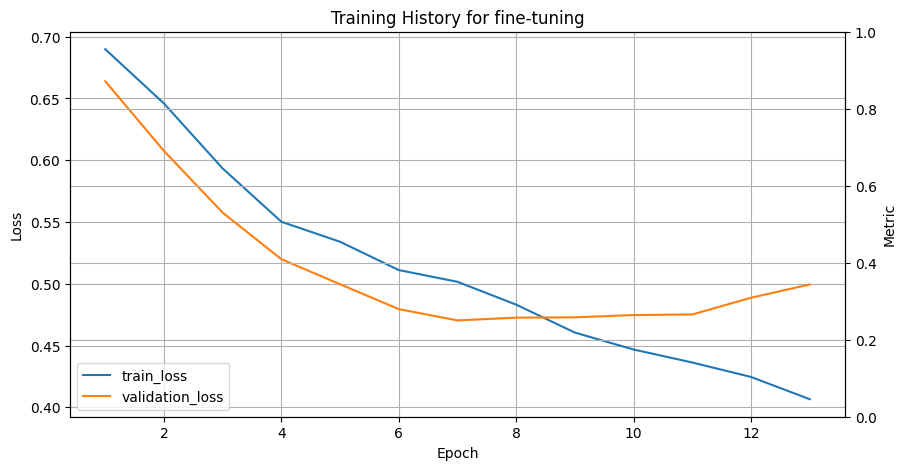

In [16]:
# Get loss, val_loss, and the computed metric from history
loss = [x['loss'] for x in history if 'loss' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

# Truncate the longer list to the size of the shorter one
min_length = min(len(loss), len(val_loss))
loss = loss[:min_length]
val_loss = val_loss[:min_length]

# Get spearman (for regression) or accuracy value (for classification)
if [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x] != []:
    metric = [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x]
else:
    metric = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]

epochs = [x['epoch'] for x in history if 'loss' in x]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot loss and val_loss on the first y-axis
line1 = ax1.plot(epochs, loss, label='train_loss')
line2 = ax1.plot(epochs, val_loss, label='validation_loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot the computed metric on the second y-axis
#line3 = ax2.plot(epochs, metric, color='red', label='validation_metric')
ax2.set_ylabel('Metric')
ax2.set_ylim([0, 1])

# Add grid lines
ax1.grid(True)
ax2.grid(True)

# Combine the lines from both y-axes and create a single legend
lines = line1 + line2 
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')

# Show the plot
plt.title("Training History for fine-tuning")
plt.savefig(f"../Plots/Without_3rdline_Training_History_new.pdf")
plt.show()

In [17]:
def save_model(model,filepath):
# Saves all parameters that were changed during finetuning

    # Create a dictionary to hold the non-frozen parameters
    non_frozen_params = {}

    # Iterate through all the model parameters
    for param_name, param in model.named_parameters():
        # If the parameter has requires_grad=True, add it to the dictionary
        if param.requires_grad:
            non_frozen_params[param_name] = param

    # Save only the finetuned parameters 
    torch.save(non_frozen_params, filepath)

    
def load_model(filepath, num_labels=2):
# Creates a new PT5 model and loads the finetuned weights from a file

    # load a new model
    model, tokenizer = PT5_classification_model(num_labels=num_labels, dropout=0.4882243131202929, lora_rank=24, lora_init_scale=0.01370043600756871, lora_scaling_rank=5)
    
    # Load the non-frozen parameters from the saved file
    non_frozen_params = torch.load(filepath)

    # Assign the non-frozen parameters to the corresponding parameters of the model
    for param_name, param in model.named_parameters():
        if param_name in non_frozen_params:
            param.data = non_frozen_params[param_name].data

    return tokenizer, model

In [ ]:
# def save_model(model, filepath):
#     torch.save(model.state_dict(), filepath)

# save_model(model, "../finetuned_model.pth")

{'lr': 0.00010175943017273118, 'batch': 8, 'accum': 2, 'dropout_rate': 0.4882243131202929, 'weight_decay': 0.00014993579804161342, 'warmup_pct': 0.18496515086758566, 'lora_rank': 24, 'lora_init_scale': 0.01370043600756871, 'lora_scaling_rank': 5}

In [18]:
# tokenizer, model_reload = load_model("../finetuned_model.pth", num_labels=2)
tokenizer, model_reload = load_model("model_output/finetuned_model_D_and_P_balance_dataset.pth",num_labels=2)

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 15355907.0



In [19]:
# Put both models to the same device
model=model.to("cpu")
model_reload=model_reload.to("cpu")

# Iterate through the parameters of the two models and compare the data
for param1, param2 in zip(model.parameters(), model_reload.parameters()):
    if not torch.equal(param1.data, param2.data):
        print("Models have different weights")
        break
else:
    print("Models have identical weights")

Models have identical weights


In [ ]:
# model = from_pretrained("model_output")

In [20]:
from Bio import SeqIO
import pandas as pd

sequences = []

local_fasta_path = '../src/input_datasets/test_Pos_Neg_ST.fasta'

# Load FASTA file using Biopython
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])
    
local_fasta_path = '../src/input_datasets/test_Pos_Neg_Y.fasta'

# Load FASTA file using Biopython
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display the dataframe
df.head(5)


,name,sequence,label
0,sp|Q8WUI4|HDAC7_HUMAN%342%358,ERLSGSGLHWPLSRTRSEPLPPSATAPPPPGPM,1
1,sp|Q13950|RUNX2_HUMAN%416%432,THYHTYLPPPYPGSSQSQSGPFQTSSTPYLYYG,1
2,sp|Q15796|SMAD2_HUMAN%229%245,DGETSDQQLNQSMDTGSPAELSPTTLSPVNHSL,1
3,sp|P05787|K2C8_HUMAN%416%432,TSGYAGGLSSAYGGLTSPGLSYSLGSSFGSGAG,1
4,sp|Q92736|RYR2_HUMAN%2798%2814,MALYNRTRRISQTSQVSVDAAHGYSPRAIDMSN,1


In [21]:
my_test=df[["sequence", "label"]]

print(my_test.head(5))

'''
my_test["sequence"]=my_test["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
my_test['sequence']=my_test.apply(lambda row : " ".join(row["sequence"]), axis = 1)
'''

#Using .loc ensures that you are modifying the original DataFrame rather than a view of it, which helps avoid the SettingWithCopyWarning.
# Replace characters in the "sequence" column
my_test.loc[:, "sequence"] = my_test["sequence"].str.replace('|'.join(["O", "B", "U", "Z"]), "X", regex=True)

# Convert each sequence to a space-separated string
my_test.loc[:, 'sequence'] = my_test.apply(lambda row: " ".join(row["sequence"]), axis=1)


                            sequence  label
0  ERLSGSGLHWPLSRTRSEPLPPSATAPPPPGPM      1
1  THYHTYLPPPYPGSSQSQSGPFQTSSTPYLYYG      1
2  DGETSDQQLNQSMDTGSPAELSPTTLSPVNHSL      1
3  TSGYAGGLSSAYGGLTSPGLSYSLGSSFGSGAG      1
4  MALYNRTRRISQTSQVSVDAAHGYSPRAIDMSN      1


In [22]:
# Function to get the middle character
def get_middle_char(sequence):
    chars = sequence.split()
    middle_index = len(chars) // 2
    return chars[middle_index]

# Apply the function to get the middle characters
my_test['middle_char'] = my_test['sequence'].apply(get_middle_char)

# Split the DataFrame
my_test_S = my_test[my_test['middle_char'] == 'S'].drop(columns=['middle_char'])
my_test_T = my_test[my_test['middle_char'] == 'T'].drop(columns=['middle_char'])
my_test_Y = my_test[my_test['middle_char'] == 'Y'].drop(columns=['middle_char'])
my_test_ST = my_test[my_test['middle_char'].isin(['S', 'T'])].drop(columns=['middle_char'])

In [23]:
my_test = my_test_Y

In [24]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_auc_score
from tabulate import tabulate

# Set the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_reload.to(device)

# create Dataset
test_set=create_dataset(tokenizer,list(my_test['sequence']),list(my_test['label']))
# make compatible with torch DataLoader
test_set = test_set.with_format("torch", device=device)

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# Put the model in evaluation mode
model_reload.eval()

# Make predictions on the test dataset
raw_logits = []
labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # add batch results (logits) to predictions
        raw_logits += model_reload(input_ids, attention_mask=attention_mask).logits.tolist()
        labels += batch["labels"].tolist()

# Convert logits to predictions
raw_logits = np.array(raw_logits)
predictions = np.argmax(raw_logits, axis=1)

# Calculate metrics
conf_matrix = confusion_matrix(labels, predictions)
tn, fp, fn, tp = conf_matrix.ravel()

mcc = matthews_corrcoef(labels, predictions)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy = accuracy_score(labels, predictions)
roc_auc = roc_auc_score(labels, raw_logits[:, 1])  # Assuming binary classification, adjust accordingly


metrics_table = [
    ["MCC", "Specificity", "Sensitivity", "Accuracy", "ROC-AUC"],
    [mcc, specificity, sensitivity, accuracy, roc_auc]
]

print(tabulate(metrics_table, headers="firstrow", tablefmt="grid"))
print(conf_matrix)


100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.01it/s]

+----------+---------------+---------------+------------+-----------+
|      MCC |   Specificity |   Sensitivity |   Accuracy |   ROC-AUC |
+==========+===============+===============+============+===========+
| 0.784465 |      0.769231 |             1 |       0.88 |  0.956731 |
+----------+---------------+---------------+------------+-----------+
[[20  6]
 [ 0 24]]


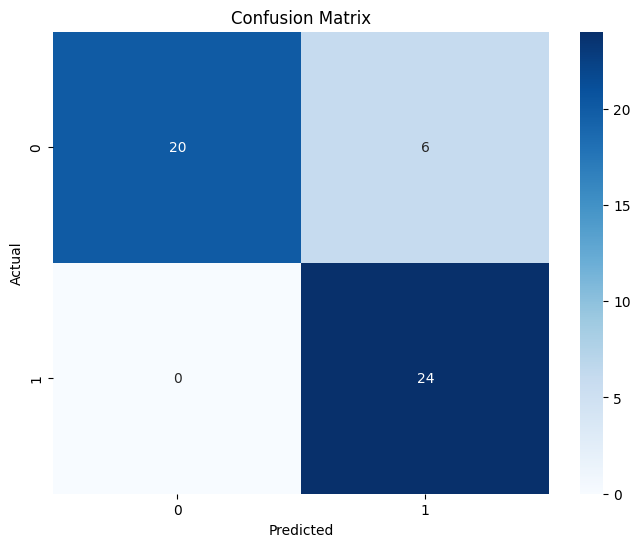

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define class labels
class_labels = ['0', '1']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(f"../Plots/Confusion_matrix_for_dephos_new.pdf")
plt.show()


In [26]:
my_test = my_test_ST

In [27]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_auc_score
from tabulate import tabulate

# Set the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_reload.to(device)

# create Dataset
test_set=create_dataset(tokenizer,list(my_test['sequence']),list(my_test['label']))
# make compatible with torch DataLoader
test_set = test_set.with_format("torch", device=device)

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# Put the model in evaluation mode
model_reload.eval()

# Make predictions on the test dataset
raw_logits = []
labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # add batch results (logits) to predictions
        raw_logits += model_reload(input_ids, attention_mask=attention_mask).logits.tolist()
        labels += batch["labels"].tolist()

# Convert logits to predictions
raw_logits = np.array(raw_logits)
predictions = np.argmax(raw_logits, axis=1)

# Calculate metrics
conf_matrix = confusion_matrix(labels, predictions)
tn, fp, fn, tp = conf_matrix.ravel()

mcc = matthews_corrcoef(labels, predictions)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy = accuracy_score(labels, predictions)
roc_auc = roc_auc_score(labels, raw_logits[:, 1])  # Assuming binary classification, adjust accordingly


metrics_table = [
    ["MCC", "Specificity", "Sensitivity", "Accuracy", "ROC-AUC"],
    [mcc, specificity, sensitivity, accuracy, roc_auc]
]

print(tabulate(metrics_table, headers="firstrow", tablefmt="grid"))
print(conf_matrix)


100%|███████████████████████████████████████████████████████████████████████████████| 28/28 [00:04<00:00,  6.65it/s]

+----------+---------------+---------------+------------+-----------+
|      MCC |   Specificity |   Sensitivity |   Accuracy |   ROC-AUC |
+==========+===============+===============+============+===========+
| 0.627874 |      0.808036 |       0.81982 |   0.813901 |  0.883687 |
+----------+---------------+---------------+------------+-----------+
[[181  43]
 [ 40 182]]


In [20]:
import umap

def apply_umap(embeddings, n_components=2, n_neighbors=5, min_dist=0.01, metric='euclidean'):
    umap_model = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric
    )
    umap_embeddings = umap_model.fit_transform(embeddings)
    return umap_embeddings

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_umap(embeddings, labels):
    df = pd.DataFrame({
        "UMAP1": embeddings[:, 0],
        "UMAP2": embeddings[:, 1],
        "Label": labels
    })
    plt.figure(figsize=(10, 8))
    scatter = sns.scatterplot(
        x="UMAP1", y="UMAP2", hue="Label", data=df, palette={0: "blue", 1: "magenta"}, s=50, alpha=0.9
    )
    plt.title("UMAP Visualization of Embeddings")
    plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc=2)
    plt.savefig("../Plots/UMAP_Visualization_of_Embeddings_ST.pdf", bbox_inches='tight')
    plt.show()
    
def get_embeddings(model, tokenizer, sequences, batch_size=32, device="cuda"):
    embeddings = []
    model = model.to(device)
    model.eval()

    for i in range(0, len(sequences), batch_size):
        batch = sequences[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            hidden_states = outputs.hidden_states[-2].detach().cpu().numpy()
            embeddings.extend(hidden_states[:, 0, :])

        print(f"Processed batch {i // batch_size + 1}/{len(sequences) // batch_size + 1}")

    return np.array(embeddings)

In [38]:
# Function to get the middle character
def get_middle_char(sequence):
    chars = list(sequence)
    middle_index = len(chars) // 2
    return chars[middle_index]

valid_df = df

# Apply the function to get the middle characters
valid_df['middle_char'] = valid_df['sequence'].apply(get_middle_char)

valid_df = valid_df[valid_df['middle_char'] == 'T'].drop(columns=['middle_char'])

In [39]:
valid_df

,name,sequence,label
180,sp|Q9GZM8|NDEL1_HUMAN%203%219,CEKMDSAVQASLSLPATPVGKGTENTFPSPKAI,1
181,sp|Q8N163|CCAR2_HUMAN%438%454,EWEALCQQKAAEAAPPTQEAQGETEPTEQAPDA,1
182,sp|P10636-8|TAU_HUMAN%196%212,GYSSPGSPGTPGSRSRTPSLPTPPTREPKKVAV,1
183,sp|Q02241|KIF23_HUMAN%434%450,QEVEVARPVDKAICGLTPGRRYRNQPRGPVGNE,1
184,sp|Q04206|TF65_HUMAN%419%435,QAVAPPAPKPTQAGEGTLSEALLQLQFDDEDLG,1
...,...,...,...
441,sp|Q76N33|STALP_MOUSE%326%342,ENVEELFNVQDQHGLLTLGWIHTHPTQTAFLSS,0
442,sp|P49790|NU153_HUMAN%1098%1114,FVLGRTEEKQQEPVTSTSLVFGKKADNEEPKCQ,0
443,sp|Q8NFC6|BD1L1_HUMAN%2789%2805,DVLDSRIETAQRQCPETEPHDTKEENSRDLEEL,0
444,sp|Q5T6F2|UBAP2_HUMAN%514%530,SKIPASAVEMPGSADVTGLNVQFGALEFGSEPS,0


/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0

Processed batch 1/3
Processed batch 2/3
Processed batch 3/3


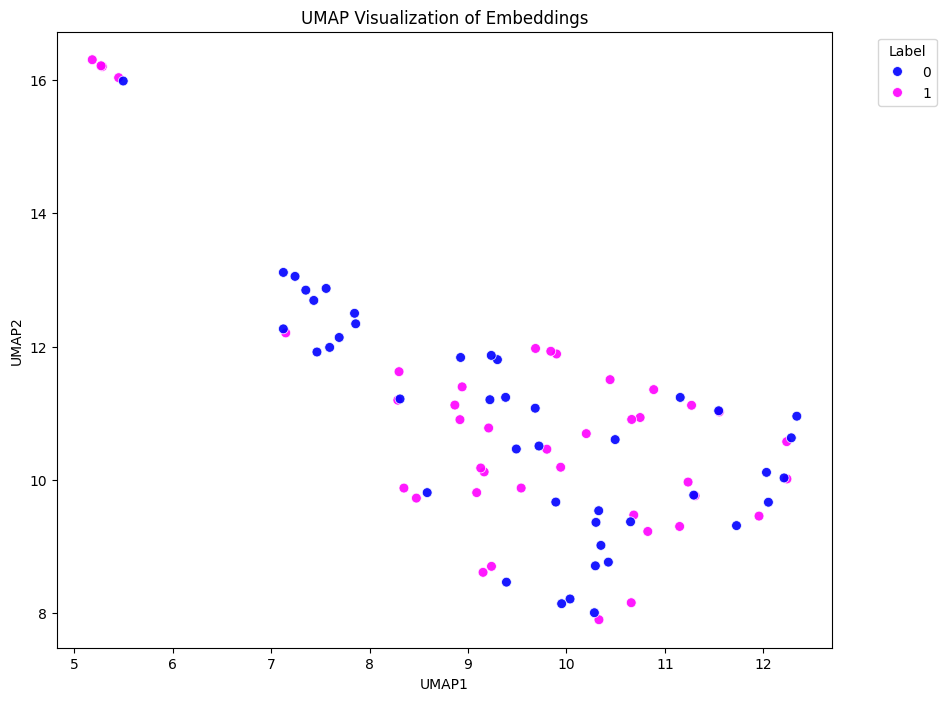

In [40]:
# valid_df = my_valid

# tokenizer, model_reload = load_model("../finetuned_model.pth", num_labels=2)
tokenizer, model_reload = load_model("model_output/finetuned_model_ST.pth",num_labels=2)

valid_df["sequence"] = valid_df["sequence"].str.replace('|'.join(["O", "B", "U", "Z"]), "X", regex=True)
valid_df["sequence"] = valid_df["sequence"].apply(lambda x: " ".join(x))

valid_sequences = list(valid_df['sequence'])
valid_embeddings = get_embeddings(model_reload, tokenizer, valid_sequences)

umap_embeddings = apply_umap(valid_embeddings)


labels = list(valid_df['label'])

plot_umap(umap_embeddings, labels)
